사용 가능한 한글 폰트: ['NanumGothic', 'NanumBarunGothic', 'NanumSquareRound', 'NanumSquare', 'NanumGothicCoding', 'NanumMyeongjo']
NanumGothic 폰트 발견: /usr/share/fonts/truetype/nanum/NanumGothic.ttf
✅ 한글 폰트 설정 완료: NanumGothic
현재 설정된 폰트: ['NanumGothic']


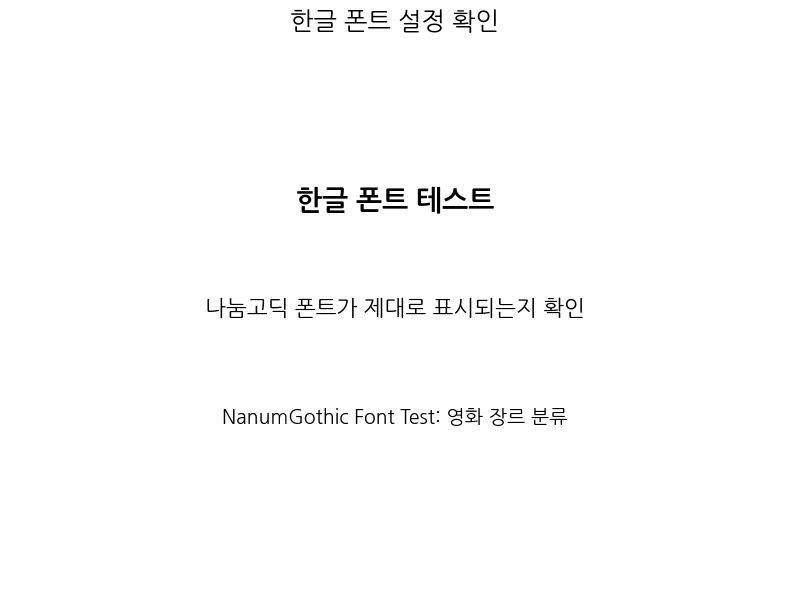

matplotlib 한글 폰트 설정이 완료되었습니다.


In [1]:
# matplotlib에서 한글 폰트 설정 (NanumGothic)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# matplotlib 폰트 캐시 새로고침
fm._load_fontmanager(try_read_cache=False)

# 시스템에서 사용 가능한 한글 폰트 찾기
korean_fonts = []
for font in fm.fontManager.ttflist:
    if any(keyword in font.name for keyword in ['Korean', 'Nanum', 'Malgun', 'Dotum', 'Gulim']):
        korean_fonts.append(font.name)

# 중복 제거
korean_fonts = list(set(korean_fonts))
print("사용 가능한 한글 폰트:", korean_fonts)

# NanumGothic 폰트 경로 확인
nanum_paths = [
    '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
    '/System/Library/Fonts/NanumGothic.ttc',
    '/Library/Fonts/NanumGothic.ttc'
]

nanum_available = False
for path in nanum_paths:
    if os.path.exists(path):
        print(f"NanumGothic 폰트 발견: {path}")
        nanum_available = True
        break

# 한글 폰트 설정 (우선순위별로 시도)
font_candidates = ['NanumGothic', 'NanumGothicOTF', 'Nanum Gothic', 'Malgun Gothic', 'DejaVu Sans']

font_set = False
for font_name in font_candidates:
    try:
        plt.rcParams['font.family'] = font_name
        # 테스트용 간단한 플롯으로 폰트 확인
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.text(0.5, 0.5, '한글 테스트: 나눔고딕', fontsize=16, ha='center', va='center')
        ax.set_title('한글 폰트 테스트')
        plt.close(fig)  # 실제로 표시하지 않고 닫기
        print(f"✅ 한글 폰트 설정 완료: {font_name}")
        font_set = True
        break
    except Exception as e:
        print(f"❌ {font_name} 설정 실패: {e}")
        continue

if not font_set:
    # 기본 폰트로 설정하고 마이너스 기호 문제 해결
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("⚠️ 한글 폰트를 찾을 수 없어 기본 폰트를 사용합니다.")

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 현재 설정된 폰트 확인
current_font = plt.rcParams['font.family']
print(f"현재 설정된 폰트: {current_font}")

# 한글 폰트 테스트
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.7, '한글 폰트 테스트', fontsize=20, ha='center', va='center', weight='bold')
ax.text(0.5, 0.5, '나눔고딕 폰트가 제대로 표시되는지 확인', fontsize=16, ha='center', va='center')
ax.text(0.5, 0.3, 'NanumGothic Font Test: 영화 장르 분류', fontsize=14, ha='center', va='center')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('한글 폰트 설정 확인', fontsize=18)
ax.axis('off')
plt.tight_layout()
plt.show()

print("matplotlib 한글 폰트 설정이 완료되었습니다.")

# 멀티모달 융합 기반 영화 장르 예측 모델 구현

이 노트북은 MM-IMDb 데이터셋을 활용하여 다양한 멀티모달 융합 기법으로 영화 장르를 예측하는 모델을 구현하고 성능을 비교 평가합니다.

## 주요 구현 내용
- 데이터 로딩 및 전처리: MM-IMDb 데이터셋 로딩, 이미지/텍스트 전처리
- 특징 추출 모델: ResNet50, ViT, BERT, RoBERTa
- 융합 전략: Early Fusion, Late Fusion, Attention Fusion, Cross-Attention Fusion
- 평가 지표: Accuracy, Precision, Recall, F1-score, ROC-AUC, mAP

## 1. 필요 라이브러리 임포트

In [2]:
# 기본 라이브러리
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 이미지 처리
import cv2
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# 딥러닝 모델
import timm  # Vision Transformer용
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

# 평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# 시각화
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# 기타 유틸리티
import warnings
warnings.filterwarnings('ignore')

# 재현성 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. 데이터 로딩 및 전처리

In [3]:
# 테스트 모드 설정 (빠른 실험을 위한 설정)
TEST_MODE = True  # True: 데이터 일부만 사용, False: 전체 데이터 사용
TEST_DATA_RATIO = 0.01  # 테스트 모드시 사용할 데이터 비율

# 데이터 경로 설정
DATA_ROOT = "/home/mingky/workspace/mmimdb_test/data/mmimdb"
DATASET_PATH = os.path.join(DATA_ROOT, "dataset")
SPLIT_PATH = os.path.join(DATA_ROOT, "split.json")

# 분할 정보 로드
with open(SPLIT_PATH, 'r') as f:
    splits = json.load(f)
    
train_ids = splits['train']
val_ids = splits['val'] if 'val' in splits else splits['dev'] 
test_ids = splits['test']

# 테스트 모드일 경우 데이터 일부만 사용
if TEST_MODE:
    import random
    random.seed(42)  # 재현성을 위한 시드 설정
    
    num_train = int(len(train_ids) * TEST_DATA_RATIO)
    num_val = int(len(val_ids) * TEST_DATA_RATIO)
    num_test = int(len(test_ids) * TEST_DATA_RATIO)
    
    train_ids = random.sample(train_ids, num_train)
    val_ids = random.sample(val_ids, num_val)
    test_ids = random.sample(test_ids, num_test)
    
    print(f"🧪 TEST MODE 활성화됨 (데이터의 {TEST_DATA_RATIO*100}%만 사용)")

print(f"Train set: {len(train_ids)} samples")
print(f"Validation set: {len(val_ids)} samples")
print(f"Test set: {len(test_ids)} samples")

🧪 TEST MODE 활성화됨 (데이터의 1.0%만 사용)
Train set: 155 samples
Validation set: 26 samples
Test set: 77 samples


In [4]:
# 모든 장르 목록 가져오기
def get_all_genres():
    all_genres = set()
    for file_id in train_ids:
        json_path = os.path.join(DATASET_PATH, f"{file_id}.json")
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                movie_data = json.load(f)
                if 'genres' in movie_data:
                    all_genres.update(movie_data['genres'])
    
    return sorted(list(all_genres))

# 장르 목록
genre_list = get_all_genres()
genre_to_idx = {genre: idx for idx, genre in enumerate(genre_list)}
idx_to_genre = {idx: genre for idx, genre in enumerate(genre_list)}

print(f"Total number of genres: {len(genre_list)}")
print(f"Genres: {genre_list}")

Total number of genres: 23
Genres: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


In [5]:
# MM-IMDb 데이터셋 클래스 정의
class MMIMDbDataset(Dataset):
    def __init__(self, movie_ids, dataset_path, genre_to_idx, 
                 img_transform=None, text_tokenizer=None, max_length=512):
        self.movie_ids = movie_ids
        self.dataset_path = dataset_path
        self.genre_to_idx = genre_to_idx
        self.img_transform = img_transform
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length
        self.num_labels = len(genre_to_idx)
        
        # 유효한 ID만 필터링 (이미지와 JSON 파일이 모두 있는 경우)
        self.valid_ids = []
        for movie_id in tqdm(movie_ids, desc="Validating dataset"):
            img_path = os.path.join(dataset_path, f"{movie_id}.jpeg")
            json_path = os.path.join(dataset_path, f"{movie_id}.json")
            
            if os.path.exists(img_path) and os.path.exists(json_path):
                self.valid_ids.append(movie_id)
        
        print(f"Found {len(self.valid_ids)} valid samples out of {len(movie_ids)}")
    
    def __len__(self):
        return len(self.valid_ids)
    
    def __getitem__(self, idx):
        movie_id = self.valid_ids[idx]
        img_path = os.path.join(self.dataset_path, f"{movie_id}.jpeg")
        json_path = os.path.join(self.dataset_path, f"{movie_id}.json")
        
        # 이미지 로드 및 전처리
        try:
            image = Image.open(img_path).convert('RGB')
            if self.img_transform:
                image = self.img_transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # 오류 발생 시 임의의 검은색 이미지 생성
            image = torch.zeros((3, 224, 224))
        
        # JSON 데이터 로드
        with open(json_path, 'r') as f:
            movie_data = json.load(f)
        
        # 텍스트 추출 및 전처리
        plot = " ".join(movie_data.get('plot', [""]))
        
        if self.text_tokenizer:
            text_encoding = self.text_tokenizer(
                plot,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = text_encoding['input_ids'].squeeze()
            attention_mask = text_encoding['attention_mask'].squeeze()
            text_inputs = {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }
        else:
            text_inputs = plot
        
        # 장르 라벨 생성 (원-핫 인코딩)
        genres = movie_data.get('genres', [])
        labels = torch.zeros(self.num_labels)
        for genre in genres:
            if genre in self.genre_to_idx:
                labels[self.genre_to_idx[genre]] = 1.0
        
        return {
            'image': image,
            'text': text_inputs,
            'labels': labels,
            'movie_id': movie_id,
            'plot': plot
        }

In [6]:
# 이미지 변환 정의
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 텍스트 토크나이저 설정
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# 데이터셋 생성 (BERT 토크나이저 사용)
train_dataset = MMIMDbDataset(
    train_ids, DATASET_PATH, genre_to_idx, 
    img_transform=image_transforms['train'], 
    text_tokenizer=bert_tokenizer
)

val_dataset = MMIMDbDataset(
    val_ids, DATASET_PATH, genre_to_idx, 
    img_transform=image_transforms['val'], 
    text_tokenizer=bert_tokenizer
)

test_dataset = MMIMDbDataset(
    test_ids, DATASET_PATH, genre_to_idx, 
    img_transform=image_transforms['test'], 
    text_tokenizer=bert_tokenizer
)

# 데이터 로더 설정
batch_size = 16

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

Validating dataset:   0%|          | 0/155 [00:00<?, ?it/s]

Found 155 valid samples out of 155


Validating dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Found 26 valid samples out of 26


Validating dataset:   0%|          | 0/77 [00:00<?, ?it/s]

Found 77 valid samples out of 77


## 3. 모델 아키텍처 구현

### 3.1 특징 추출기 구현

In [7]:
# 이미지 특징 추출기
class ImageFeatureExtractor(nn.Module):
    def __init__(self, feature_extractor='resnet50', pretrained=True, freeze=True):
        super(ImageFeatureExtractor, self).__init__()
        self.feature_extractor = feature_extractor
        
        if feature_extractor == 'resnet50':
            self.model = models.resnet50(pretrained=pretrained)
            # 마지막 FC 레이어 제거
            self.model = nn.Sequential(*list(self.model.children())[:-1])
            self.feature_dim = 2048
        elif feature_extractor == 'vit':
            # ViT (Vision Transformer)
            self.model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
            self.feature_dim = self.model.head.in_features
            # 헤드 제거
            self.model.head = nn.Identity()
            
        # 특징 추출기 레이어 고정 (선택적)
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
                
    def forward(self, x):
        features = self.model(x)
        # Reshape: 배치 차원을 유지하면서 flatten
        if self.feature_extractor == 'resnet50':
            features = features.view(features.size(0), -1)
        return features

# 텍스트 특징 추출기
class TextFeatureExtractor(nn.Module):
    def __init__(self, feature_extractor='bert', pretrained=True, freeze=True):
        super(TextFeatureExtractor, self).__init__()
        self.feature_extractor = feature_extractor
        
        if feature_extractor == 'bert':
            self.model = BertModel.from_pretrained('bert-base-uncased')
            self.feature_dim = 768
        elif feature_extractor == 'roberta':
            self.model = RobertaModel.from_pretrained('roberta-base')
            self.feature_dim = 768
            
        # 특징 추출기 레이어 고정 (선택적)
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
                
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        # [CLS] 토큰 임베딩 사용
        return outputs.last_hidden_state[:, 0, :]

### 3.2 융합 모듈 구현

In [8]:
# 1. Early Fusion (단순 연결)
class EarlyFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim):
        super(EarlyFusionModule, self).__init__()
        self.fusion_dim = img_feat_dim + text_feat_dim
        
    def forward(self, img_features, text_features):
        # 단순히 두 특징 벡터를 연결
        fused_features = torch.cat([img_features, text_features], dim=1)
        return fused_features

# 2. Late Fusion (분류 결과 결합)
class LateFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim, num_classes):
        super(LateFusionModule, self).__init__()
        self.fusion_dim = num_classes
        
        # 이미지 분류기
        self.img_classifier = nn.Sequential(
            nn.Linear(img_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # 텍스트 분류기
        self.text_classifier = nn.Sequential(
            nn.Linear(text_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # 가중치 학습 파라미터
        self.alpha = nn.Parameter(torch.FloatTensor([0.5]))
        
    def forward(self, img_features, text_features):
        # 각 모달리티별 예측
        img_preds = self.img_classifier(img_features)
        text_preds = self.text_classifier(text_features)
        
        # 가중치 결합
        alpha = torch.sigmoid(self.alpha)
        fused_preds = alpha * img_preds + (1 - alpha) * text_preds
        
        return fused_preds

# 3. Attention Fusion (모달리티 간 어텐션)
class AttentionFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim):
        super(AttentionFusionModule, self).__init__()
        
        # 투영 차원
        self.proj_dim = 512
        
        # 특징 투영 레이어
        self.img_projection = nn.Linear(img_feat_dim, self.proj_dim)
        self.text_projection = nn.Linear(text_feat_dim, self.proj_dim)
        
        # 어텐션 레이어
        self.attention = nn.Sequential(
            nn.Linear(self.proj_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        
        self.fusion_dim = self.proj_dim
        
    def forward(self, img_features, text_features):
        # 특징 투영
        img_proj = self.img_projection(img_features)
        text_proj = self.text_projection(text_features)
        
        # 연결하여 어텐션 가중치 계산
        combined = torch.cat([img_proj, text_proj], dim=1)
        attention_weights = self.attention(combined)
        
        # 가중치 적용 및 결합
        fused_features = attention_weights[:, 0].unsqueeze(1) * img_proj + \
                          attention_weights[:, 1].unsqueeze(1) * text_proj
        
        return fused_features

# 4. Cross-Attention Fusion (교차 어텐션)
class CrossAttentionFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim):
        super(CrossAttentionFusionModule, self).__init__()
        
        # 투영 차원
        self.proj_dim = 512
        
        # 특징 투영 레이어
        self.img_projection = nn.Linear(img_feat_dim, self.proj_dim)
        self.text_projection = nn.Linear(text_feat_dim, self.proj_dim)
        
        # Cross-Attention 레이어
        self.q_img = nn.Linear(self.proj_dim, self.proj_dim)
        self.k_text = nn.Linear(self.proj_dim, self.proj_dim)
        self.v_text = nn.Linear(self.proj_dim, self.proj_dim)
        
        self.q_text = nn.Linear(self.proj_dim, self.proj_dim)
        self.k_img = nn.Linear(self.proj_dim, self.proj_dim)
        self.v_img = nn.Linear(self.proj_dim, self.proj_dim)
        
        self.norm1 = nn.LayerNorm(self.proj_dim)
        self.norm2 = nn.LayerNorm(self.proj_dim)
        
        self.fusion_dim = self.proj_dim * 2
        
    def forward(self, img_features, text_features):
        # 특징 투영
        img_proj = self.img_projection(img_features)
        text_proj = self.text_projection(text_features)
        
        # 이미지 -> 텍스트 Cross-Attention
        q_img = self.q_img(img_proj)
        k_text = self.k_text(text_proj)
        v_text = self.v_text(text_proj)
        
        # 스케일링된 내적 어텐션
        attn_scores = torch.matmul(q_img, k_text.transpose(-2, -1)) / (self.proj_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attended_text = torch.matmul(attn_weights, v_text)
        img_attended = self.norm1(img_proj + attended_text)
        
        # 텍스트 -> 이미지 Cross-Attention
        q_text = self.q_text(text_proj)
        k_img = self.k_img(img_proj)
        v_img = self.v_img(img_proj)
        
        attn_scores = torch.matmul(q_text, k_img.transpose(-2, -1)) / (self.proj_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attended_img = torch.matmul(attn_weights, v_img)
        text_attended = self.norm2(text_proj + attended_img)
        
        # 최종 결합
        fused_features = torch.cat([img_attended, text_attended], dim=1)
        
        return fused_features

### 3.3 최종 멀티모달 모델 구현

In [9]:
# 멀티모달 융합 모델
class MultimodalModel(nn.Module):
    def __init__(self, num_classes, img_extractor='resnet50', text_extractor='bert', 
                 fusion_method='early', freeze_extractors=True):
        super(MultimodalModel, self).__init__()
        
        # 이미지 특징 추출기 초기화
        self.img_extractor = ImageFeatureExtractor(img_extractor, pretrained=True, freeze=freeze_extractors)
        
        # 텍스트 특징 추출기 초기화
        self.text_extractor = TextFeatureExtractor(text_extractor, pretrained=True, freeze=freeze_extractors)
        
        # 융합 방식 설정
        self.fusion_method = fusion_method
        
        # 적절한 융합 모듈 선택
        if fusion_method == 'early':
            self.fusion_module = EarlyFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.img_extractor.feature_dim + self.text_extractor.feature_dim
            
        elif fusion_method == 'late':
            self.fusion_module = LateFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim, num_classes
            )
            # Late Fusion은 직접 출력값 생성
            fusion_dim = num_classes
            
        elif fusion_method == 'attention':
            self.fusion_module = AttentionFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.fusion_module.fusion_dim
            
        elif fusion_method == 'cross-attention':
            self.fusion_module = CrossAttentionFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.fusion_module.fusion_dim
            
        else:
            raise ValueError(f"Unknown fusion method: {fusion_method}")
        
        # 분류기 (Late Fusion은 필요 없음)
        if fusion_method != 'late':
            self.classifier = nn.Sequential(
                nn.Linear(fusion_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, num_classes)
            )
            
    def forward(self, image, text_inputs):
        # 이미지 특징 추출
        img_features = self.img_extractor(image)
        
        # 텍스트 특징 추출
        text_features = self.text_extractor(
            input_ids=text_inputs['input_ids'], 
            attention_mask=text_inputs['attention_mask']
        )
        
        # 특징 융합
        if self.fusion_method == 'late':
            # Late Fusion은 직접 예측값 반환
            logits = self.fusion_module(img_features, text_features)
        else:
            # 다른 융합 방법들은 융합된 특징 반환
            fused_features = self.fusion_module(img_features, text_features)
            logits = self.classifier(fused_features)
            
        return logits

# 단일 모달 모델 (이미지만 또는 텍스트만)
class SingleModalModel(nn.Module):
    def __init__(self, num_classes, modality='image', extractor='resnet50', freeze_extractor=True):
        super(SingleModalModel, self).__init__()
        
        self.modality = modality
        
        if modality == 'image':
            self.feature_extractor = ImageFeatureExtractor(extractor, pretrained=True, freeze=freeze_extractor)
        elif modality == 'text':
            self.feature_extractor = TextFeatureExtractor(extractor, pretrained=True, freeze=freeze_extractor)
        else:
            raise ValueError(f"Unknown modality: {modality}")
        
        # 분류기
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inputs):
        if self.modality == 'image':
            features = self.feature_extractor(inputs)
        else:  # text
            features = self.feature_extractor(
                input_ids=inputs['input_ids'], 
                attention_mask=inputs['attention_mask']
            )
            
        logits = self.classifier(features)
        return logits

## 4. 모델 학습 및 평가 함수

In [10]:
# 모델 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=10, device=device, early_stop_patience=5):
    
    # 학습 기록을 위한 딕셔너리
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': []
    }
    
    # 조기 종료를 위한 변수
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # 훈련 모드
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []
        
        # 훈련 데이터 처리
        for batch in tqdm(train_loader, desc="Training"):
            # 데이터 준비
            images = batch['image'].to(device)
            
            if isinstance(model, MultimodalModel):
                text_inputs = {
                    'input_ids': batch['text']['input_ids'].to(device),
                    'attention_mask': batch['text']['attention_mask'].to(device)
                }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(images, text_inputs)
                
            elif isinstance(model, SingleModalModel):
                if model.modality == 'image':
                    inputs = images
                else:  # text
                    inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            
            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 통계 업데이트
            train_loss += loss.item() * images.size(0)
            train_preds.append(torch.sigmoid(outputs).cpu().detach().numpy())
            train_targets.append(targets.cpu().numpy())
        
        # 에폭 평균 손실
        train_loss = train_loss / len(train_loader.dataset)
        
        # 예측 및 타겟 배열 결합
        train_preds = np.vstack(train_preds)
        train_targets = np.vstack(train_targets)
        
        # 임계값 적용하여 이진 분류 결과 얻기
        train_preds_binary = (train_preds > 0.5).astype(float)
        
        # 성능 지표 계산
        train_acc = accuracy_score(train_targets.flatten(), train_preds_binary.flatten())
        train_f1 = f1_score(train_targets, train_preds_binary, average='macro')
        
        # 검증 모드
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # 데이터 준비
                images = batch['image'].to(device)
                
                if isinstance(model, MultimodalModel):
                    text_inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                    targets = batch['labels'].to(device)
                    
                    # 순전파
                    outputs = model(images, text_inputs)
                    
                elif isinstance(model, SingleModalModel):
                    if model.modality == 'image':
                        inputs = images
                    else:  # text
                        inputs = {
                            'input_ids': batch['text']['input_ids'].to(device),
                            'attention_mask': batch['text']['attention_mask'].to(device)
                        }
                    targets = batch['labels'].to(device)
                    
                    # 순전파
                    outputs = model(inputs)
                
                # 손실 계산
                loss = criterion(outputs, targets)
                
                # 통계 업데이트
                val_loss += loss.item() * images.size(0)
                val_preds.append(torch.sigmoid(outputs).cpu().numpy())
                val_targets.append(targets.cpu().numpy())
        
        # 에폭 평균 손실
        val_loss = val_loss / len(val_loader.dataset)
        
        # 예측 및 타겟 배열 결합
        val_preds = np.vstack(val_preds)
        val_targets = np.vstack(val_targets)
        
        # 임계값 적용하여 이진 분류 결과 얻기
        val_preds_binary = (val_preds > 0.5).astype(float)
        
        # 성능 지표 계산
        val_acc = accuracy_score(val_targets.flatten(), val_preds_binary.flatten())
        val_f1 = f1_score(val_targets, val_preds_binary, average='macro')
        
        # 학습률 스케줄러 업데이트 (있는 경우)
        if scheduler:
            scheduler.step(val_loss)
        
        # 기록 저장
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        
        # 에폭 결과 출력
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")
        print("-" * 50)
        
        # 최고 성능 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        # 조기 종료
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # 최고 성능 모델로 복원
    if best_model_weights:
        model.load_state_dict(best_model_weights)
        
    return model, history

# 모델 평가 함수
def evaluate_model(model, test_loader, criterion, device=device):
    # 평가 모드
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 데이터 준비
            images = batch['image'].to(device)
            
            if isinstance(model, MultimodalModel):
                text_inputs = {
                    'input_ids': batch['text']['input_ids'].to(device),
                    'attention_mask': batch['text']['attention_mask'].to(device)
                }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(images, text_inputs)
                
            elif isinstance(model, SingleModalModel):
                if model.modality == 'image':
                    inputs = images
                else:  # text
                    inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            
            # 통계 업데이트
            test_loss += loss.item() * images.size(0)
            
            # 예측값 저장
            probabilities = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probabilities)
            all_preds.append((probabilities > 0.5).astype(float))
            all_targets.append(targets.cpu().numpy())
    
    # 평균 손실
    test_loss = test_loss / len(test_loader.dataset)
    
    # 예측 및 타겟 배열 결합
    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    # 평가 지표 계산
    metrics = {
        'loss': test_loss,
        'accuracy': accuracy_score(all_targets.flatten(), all_preds.flatten()),
        'precision_macro': precision_score(all_targets, all_preds, average='macro', zero_division=0),
        'recall_macro': recall_score(all_targets, all_preds, average='macro', zero_division=0),
        'f1_macro': f1_score(all_targets, all_preds, average='macro', zero_division=0),
        'precision_micro': precision_score(all_targets, all_preds, average='micro', zero_division=0),
        'recall_micro': recall_score(all_targets, all_preds, average='micro', zero_division=0),
        'f1_micro': f1_score(all_targets, all_preds, average='micro', zero_division=0),
    }
    
    # ROC-AUC 계산 (각 클래스별)
    try:
        roc_auc = roc_auc_score(all_targets, all_probs, average='macro')
        metrics['roc_auc'] = roc_auc
    except:
        metrics['roc_auc'] = float('nan')  # 에러 발생 시 NaN으로 처리
        
    # mAP(Average Precision) 계산
    try:
        mAP = average_precision_score(all_targets, all_probs, average='macro')
        metrics['mAP'] = mAP
    except:
        metrics['mAP'] = float('nan')  # 에러 발생 시 NaN으로 처리
        
    return metrics, all_preds, all_probs, all_targets

In [11]:
# 시각화 함수 정의
def plot_training_history(history, title='모델 학습 결과'):
    """학습 과정에서의 손실 및 성능 지표 시각화"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 손실 곡선
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('손실 추이')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # 정확도 곡선
    axes[1].plot(history['train_acc'], label='Train Accuracy')
    axes[1].plot(history['val_acc'], label='Validation Accuracy')
    axes[1].set_title('정확도 추이')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # F1 곡선
    axes[2].plot(history['train_f1'], label='Train F1')
    axes[2].plot(history['val_f1'], label='Validation F1')
    axes[2].set_title('F1 점수 추이')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """다중 레이블 분류를 위한 혼동 행렬 시각화"""
    # 평균 혼동 행렬 계산
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    
    fig, axes = plt.subplots(4, 6, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, (ax, cm, label) in enumerate(zip(axes, mcm, classes)):
        if i < len(classes):
            # 클래스별 혼동 행렬 시각화
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Class: {label}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticks([0.5, 1.5])
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticks([0.5, 1.5])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # 남은 축 숨기기
    for i in range(len(classes), len(axes)):
        axes[i].axis('off')
        
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
def plot_roc_curves(y_true, y_scores, classes, title='ROC Curves'):
    """클래스별 ROC 곡선 시각화"""
    from sklearn.metrics import roc_curve, auc
    
    fig, axes = plt.subplots(4, 6, figsize=(20, 15))
    axes = axes.flatten()
    
    # 전체 평균 값을 위한 변수
    all_fpr = []
    all_tpr = []
    
    for i, (ax, label) in enumerate(zip(axes, classes)):
        if i < len(classes):
            # 클래스별 ROC 곡선 계산
            fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            
            # ROC 곡선 그리기
            ax.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
            ax.plot([0, 1], [0, 1], 'k--', lw=1)
            ax.set_title(f'Class: {label}')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.legend(loc='lower right')
    
    # 남은 축 숨기기
    for i in range(len(classes), len(axes)):
        axes[i].axis('off')
        
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
def plot_model_comparison(model_results, metrics=['accuracy', 'f1_macro', 'roc_auc', 'mAP']):
    """여러 모델의 성능 비교 시각화"""
    # 모델 이름과 결과 추출
    model_names = list(model_results.keys())
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    
    if len(metrics) == 1:
        axes = [axes]
    
    for i, metric in enumerate(metrics):
        values = [model_results[model][metric] for model in model_names]
        
        # 막대 그래프 생성
        bar_plot = axes[i].bar(model_names, values, color='skyblue')
        axes[i].set_title(f'{metric.capitalize()} 비교')
        axes[i].set_ylabel(metric)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        
        # 값 표시
        for bar in bar_plot:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [12]:
# Grad-CAM 구현을 위한 클래스 (최종 수정 버전)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.features = None
        self.hooks = []
        
    def _register_hooks(self):
        """훅 등록"""
        self._remove_hooks()  # 기존 훅 제거
        
        forward_hook = self.target_layer.register_forward_hook(self.save_features)
        backward_hook = self.target_layer.register_backward_hook(self.save_gradients)
        
        self.hooks = [forward_hook, backward_hook]
    
    def save_features(self, module, input, output):
        """Forward hook: 특징 맵 저장"""
        self.features = output
    
    def save_gradients(self, module, grad_input, grad_output):
        """Backward hook: 그래디언트 저장"""
        if grad_output[0] is not None:
            self.gradients = grad_output[0]
    
    def __call__(self, x, class_idx=None):
        # 그래디언트와 특징 맵 초기화
        self.gradients = None
        self.features = None
        
        # 훅 등록
        self._register_hooks()
        
        # 모델을 평가 모드로 설정하되, 그래디언트는 활성화
        self.model.eval()
        
        try:
            # 입력 텐서에 requires_grad 설정
            x = x.requires_grad_(True)
            
            if isinstance(self.model, MultimodalModel):
                # 멀티모달 모델의 경우 이미지만 전달 (더미 텍스트 사용)
                dummy_text = {
                    'input_ids': torch.zeros((x.shape[0], 512), dtype=torch.long).to(x.device),
                    'attention_mask': torch.ones((x.shape[0], 512), dtype=torch.long).to(x.device)
                }
                logits = self.model(x, dummy_text)
            else:
                # 단일 모달 모델(이미지)
                logits = self.model(x)
            
            # 특정 클래스 지정이 없으면 최대값 사용
            if class_idx is None:
                class_idx = logits.argmax(dim=1).item()
            
            # 타겟 클래스에 대한 스코어 추출
            score = logits[0, class_idx]
            
            # 그래디언트 계산
            self.model.zero_grad()
            score.backward(retain_graph=True)
            
            # 그래디언트와 특징이 제대로 저장되었는지 확인
            if self.gradients is None or self.features is None:
                print(f"Warning: Gradients or features not captured for class {class_idx}")
                return np.zeros((x.shape[2], x.shape[3]))
            
            # 채널별 평균 그래디언트 계산
            weights = self.gradients.mean(dim=(2, 3), keepdim=True)
            
            # 특징 맵에 가중치 적용
            cam = (weights * self.features).sum(dim=1, keepdim=True)
            cam = F.relu(cam)  # ReLU 적용하여 음수 값 제거
            
            # 정규화
            cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
            cam = cam - cam.min()
            if cam.max() > 0:
                cam = cam / cam.max()
            
            return cam.squeeze().detach().cpu().numpy()  # .detach() 추가
            
        except Exception as e:
            print(f"Error in GradCAM calculation: {e}")
            return np.zeros((x.shape[2], x.shape[3]))
        
        finally:
            # 훅 제거
            self._remove_hooks()
    
    def _remove_hooks(self):
        """훅 제거"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def remove_hooks(self):
        """외부 인터페이스용 훅 제거 메서드"""
        self._remove_hooks()

# 어텐션 맵 시각화 함수
def visualize_attention(text_tokens, attention_weights, title='Attention Map'):
    """텍스트 토큰에 대한 어텐션 가중치 시각화"""
    # 불필요한 토큰 필터링 ([CLS], [SEP], [PAD] 등)
    valid_tokens = []
    valid_weights = []
    
    for token, weight in zip(text_tokens, attention_weights):
        if token not in ['[CLS]', '[SEP]', '[PAD]', '<s>', '</s>', '<pad>']:
            valid_tokens.append(token)
            valid_weights.append(weight)
    
    # 최대 30개 토큰만 시각화
    if len(valid_tokens) > 30:
        valid_tokens = valid_tokens[:30]
        valid_weights = valid_weights[:30]
    
    # 시각화
    plt.figure(figsize=(10, 4))
    
    # 히트맵 생성
    im = plt.imshow([valid_weights], cmap='YlOrRd', aspect='auto')
    
    # 축 설정
    plt.yticks([])
    plt.xticks(range(len(valid_tokens)), valid_tokens, rotation=45, ha='right')
    
    # 컬러바 추가
    plt.colorbar(im, orientation='vertical')
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("GradCAM 클래스가 최종 수정되었습니다.")

GradCAM 클래스가 최종 수정되었습니다.


## 5. 모델 훈련 및 평가

In [13]:
# 메모리 관리 유틸리티 함수들
import gc
import torch

def clear_memory():
    """GPU 및 CPU 메모리 정리 함수"""
    print("메모리 정리 중...")
    
    # 가비지 컬렉션
    gc.collect()
    
    # GPU 캐시 정리
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    
    print("메모리 정리 완료")

def get_memory_usage():
    """현재 GPU 메모리 사용량 확인"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        reserved = torch.cuda.memory_reserved() / 1024**3   # GB
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB
        
        print(f"GPU 메모리 사용량:")
        print(f"- 할당된 메모리: {allocated:.2f} GB")
        print(f"- 예약된 메모리: {reserved:.2f} GB") 
        print(f"- 전체 메모리: {total:.2f} GB")
        print(f"- 사용 가능한 메모리: {total - allocated:.2f} GB")
        
        return allocated, reserved, total
    else:
        print("CUDA를 사용할 수 없습니다.")
        return 0, 0, 0

def safe_model_to_device(model, device):
    """안전하게 모델을 디바이스로 이동"""
    try:
        # 먼저 메모리 정리
        clear_memory()
        
        # 메모리 사용량 확인
        get_memory_usage()
        
        # 모델을 디바이스로 이동
        model = model.to(device)
        
        print(f"모델이 {device}로 성공적으로 이동되었습니다.")
        return model
    
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"메모리 부족 오류 발생: {e}")
            print("메모리를 정리하고 다시 시도합니다...")
            
            # 강력한 메모리 정리
            clear_memory()
            
            # 다시 시도
            try:
                model = model.to(device)
                print(f"재시도 성공: 모델이 {device}로 이동되었습니다.")
                return model
            except RuntimeError as e2:
                print(f"재시도 실패: {e2}")
                raise e2
        else:
            raise e

# 현재 메모리 상태 확인
print("=== 현재 메모리 상태 ===")
get_memory_usage()
clear_memory()
print("\n=== 메모리 정리 후 상태 ===")
get_memory_usage()

=== 현재 메모리 상태 ===
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
메모리 정리 중...
메모리 정리 완료

=== 메모리 정리 후 상태 ===
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
메모리 정리 완료

=== 메모리 정리 후 상태 ===
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB


(0.0, 0.0, 3.813232421875)

In [14]:
# 🧪 메모리 관리 기능 테스트 (작은 모델로 테스트)

print("=== 메모리 관리 기능 테스트 ===")

# 현재 메모리 상태
get_memory_usage()

# 테스트용 작은 모델 생성
print("\n테스트용 EarlyFusion 모델 생성...")
test_model = MultimodalModel(
    len(genre_list),
    img_extractor='resnet50',
    text_extractor='bert',
    fusion_method='early',
    freeze_extractors=True  # 메모리 절약을 위해 특징 추출기 고정
)

# 안전한 디바이스 이동 테스트
print("모델을 GPU로 안전하게 이동...")
test_model = safe_model_to_device(test_model, device)

# 메모리 사용량 확인
print("\n모델 로딩 후 메모리 상태:")
get_memory_usage()

# 모델 제거 및 메모리 정리 테스트
print("\n모델 정리 및 메모리 해제...")
test_model = test_model.cpu()
del test_model
clear_memory()

print("\n정리 후 메모리 상태:")
get_memory_usage()

print("\n✅ 메모리 관리 테스트 완료!")
print("이제 아래의 개선된 학습 코드를 실행할 수 있습니다.")

=== 메모리 관리 기능 테스트 ===
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB

테스트용 EarlyFusion 모델 생성...
모델을 GPU로 안전하게 이동...
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
모델을 GPU로 안전하게 이동...
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
모델이 cuda로 성공적으로 이동되었습니다.

모델 로딩 후 메모리 상태:
GPU 메모리 사용량:
- 할당된 메모리: 0.51 GB
- 예약된 메모리: 0.56 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.31 GB

모델 정리 및 메모리 해제...
모델이 cuda로 성공적으로 이동되었습니다.

모델 로딩 후 메모리 상태:
GPU 메모리 사용량:
- 할당된 메모리: 0.51 GB
- 예약된 메모리: 0.56 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.31 GB

모델 정리 및 메모리 해제...
메모리 정리 중...
메모리 정리 완료

정리 후 메모리 상태:
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB

✅ 메모리 관리 테스트 완료!
이제 아래의 개선된 학습 코드를 실행할 수 있습니다.
메모리 정리 중...
메모리 정리 완료

정리 후 메모리 상태:
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메

총 8개의 모델을 순차적으로 학습합니다.
각 모델 학습 후 메모리를 정리하여 OutOfMemory 오류를 방지합니다.

[1/8] ResNet50 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: ResNet50
Epoch 1/10
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: ResNet50
Epoch 1/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6781, Val Loss: 0.6613
Train Acc: 0.6564, Val Acc: 0.8110
Train F1: 0.1358, Val F1: 0.0348
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6518, Val Loss: 0.6334
Train Acc: 0.8093, Val Acc: 0.8846
Train F1: 0.0911, Val F1: 0.0290
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6213, Val Loss: 0.5991
Train Acc: 0.8569, Val Acc: 0.8913
Train F1: 0.0678, Val F1: 0.0290
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5843, Val Loss: 0.5583
Train Acc: 0.8760, Val Acc: 0.8913
Train F1: 0.0543, Val F1: 0.0290
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5441, Val Loss: 0.5120
Train Acc: 0.8825, Val Acc: 0.8930
Train F1: 0.0323, Val F1: 0.0297
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4988, Val Loss: 0.4660
Train Acc: 0.8886, Val Acc: 0.8913
Train F1: 0.0304, Val F1: 0.0240
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4519, Val Loss: 0.4230
Train Acc: 0.8934, Val Acc: 0.8913
Train F1: 0.0289, Val F1: 0.0137
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4118, Val Loss: 0.3856
Train Acc: 0.8900, Val Acc: 0.8913
Train F1: 0.0216, Val F1: 0.0000
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3755, Val Loss: 0.3571
Train Acc: 0.8959, Val Acc: 0.8913
Train F1: 0.0216, Val F1: 0.0000
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3552, Val Loss: 0.3361
Train Acc: 0.8948, Val Acc: 0.8930
Train F1: 0.0246, Val F1: 0.0062
--------------------------------------------------


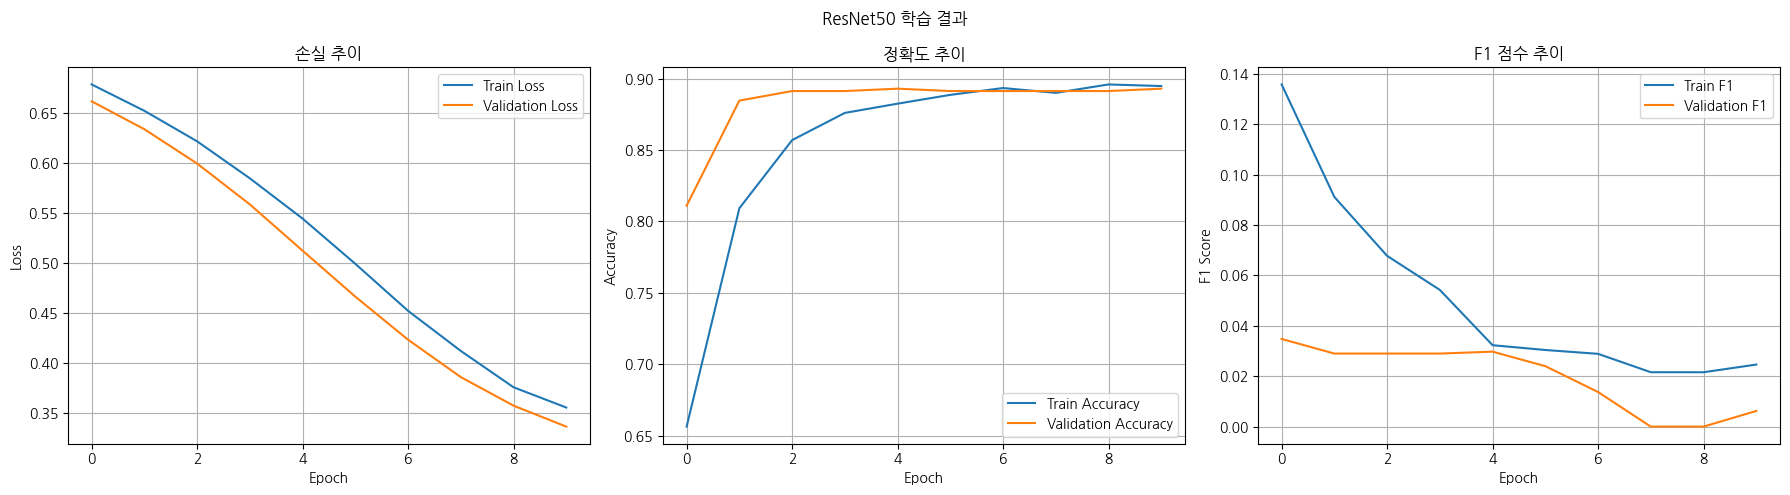

Testing:   0%|          | 0/5 [00:00<?, ?it/s]


ResNet50 평가 결과:
  loss: 0.3487
  accuracy: 0.8814
  precision_macro: 0.0217
  recall_macro: 0.0012
  f1_macro: 0.0024
  precision_micro: 0.5000
  recall_micro: 0.0048
  f1_micro: 0.0094
  roc_auc: nan
  mAP: 0.1696
모델 저장됨: saved_models/ResNet50_model_20250924_193553.pth
메모리 정리 중...
메모리 정리 완료
ResNet50 학습 및 저장 완료!
[2/8] ViT 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
ResNet50 학습 및 저장 완료!
[2/8] ViT 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: ViT
Epoch 1/10
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: ViT
Epoch 1/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6846, Val Loss: 0.6705
Train Acc: 0.5627, Val Acc: 0.6338
Train F1: 0.1465, Val F1: 0.0959
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6613, Val Loss: 0.6461
Train Acc: 0.6365, Val Acc: 0.7224
Train F1: 0.1332, Val F1: 0.0787
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6388, Val Loss: 0.6221
Train Acc: 0.7035, Val Acc: 0.8077
Train F1: 0.1229, Val F1: 0.0663
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6141, Val Loss: 0.5973
Train Acc: 0.7745, Val Acc: 0.8395
Train F1: 0.1375, Val F1: 0.0415
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5926, Val Loss: 0.5709
Train Acc: 0.7958, Val Acc: 0.8763
Train F1: 0.0836, Val F1: 0.0548
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5615, Val Loss: 0.5425
Train Acc: 0.8418, Val Acc: 0.8829
Train F1: 0.0612, Val F1: 0.0163
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5379, Val Loss: 0.5126
Train Acc: 0.8575, Val Acc: 0.8863
Train F1: 0.0633, Val F1: 0.0116
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5052, Val Loss: 0.4821
Train Acc: 0.8766, Val Acc: 0.8913
Train F1: 0.0869, Val F1: 0.0116
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4835, Val Loss: 0.4517
Train Acc: 0.8816, Val Acc: 0.8946
Train F1: 0.0498, Val F1: 0.0116
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4466, Val Loss: 0.4226
Train Acc: 0.8903, Val Acc: 0.8946
Train F1: 0.0357, Val F1: 0.0116
--------------------------------------------------


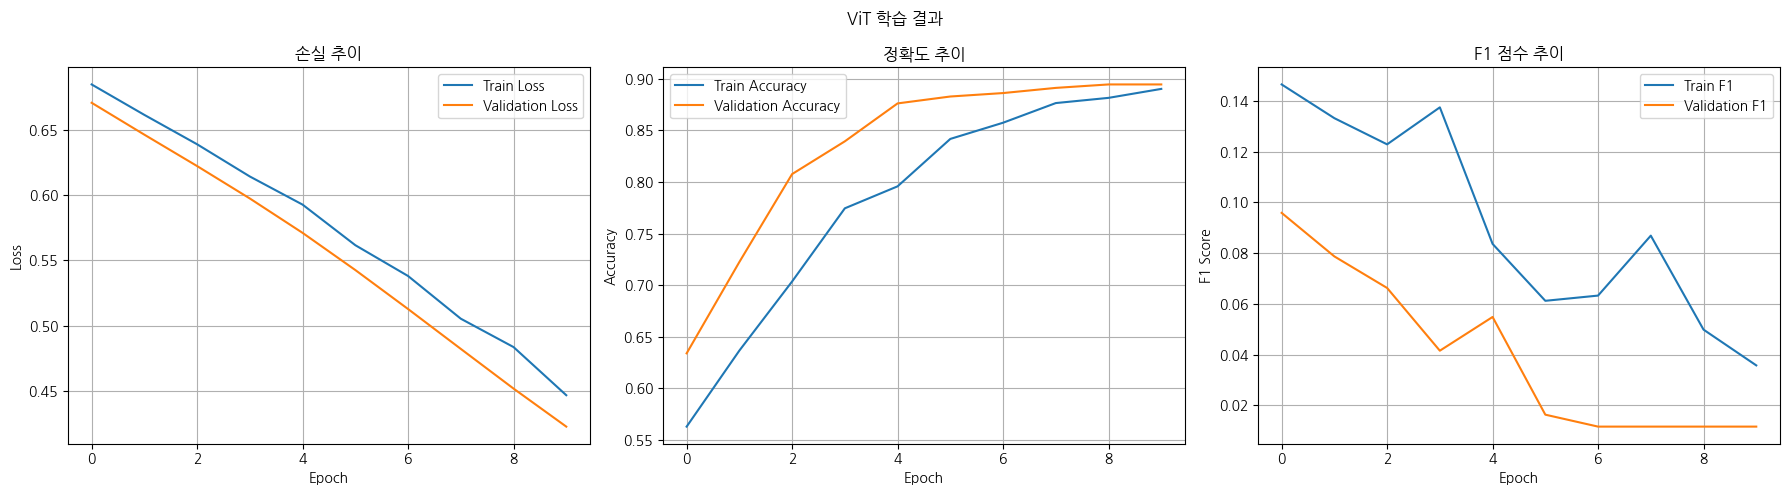

Testing:   0%|          | 0/5 [00:00<?, ?it/s]


ViT 평가 결과:
  loss: 0.4391
  accuracy: 0.8809
  precision_macro: 0.0248
  recall_macro: 0.0050
  f1_macro: 0.0083
  precision_micro: 0.4444
  recall_micro: 0.0190
  f1_micro: 0.0365
  roc_auc: nan
  mAP: 0.2190
모델 저장됨: saved_models/ViT_model_20250924_193943.pth
모델 저장됨: saved_models/ViT_model_20250924_193943.pth
메모리 정리 중...
메모리 정리 완료
ViT 학습 및 저장 완료!
[3/8] BERT 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
ViT 학습 및 저장 완료!
[3/8] BERT 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: BERT
Epoch 1/10
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: BERT
Epoch 1/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6896, Val Loss: 0.6839
Train Acc: 0.5391, Val Acc: 0.5987
Train F1: 0.1561, Val F1: 0.0992
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6801, Val Loss: 0.6735
Train Acc: 0.6306, Val Acc: 0.7007
Train F1: 0.1289, Val F1: 0.0867
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6700, Val Loss: 0.6624
Train Acc: 0.7072, Val Acc: 0.8077
Train F1: 0.1274, Val F1: 0.0712
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6604, Val Loss: 0.6501
Train Acc: 0.7568, Val Acc: 0.8528
Train F1: 0.1237, Val F1: 0.0290
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6485, Val Loss: 0.6361
Train Acc: 0.8107, Val Acc: 0.8829
Train F1: 0.1028, Val F1: 0.0290
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6347, Val Loss: 0.6199
Train Acc: 0.8429, Val Acc: 0.8896
Train F1: 0.1110, Val F1: 0.0290
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6196, Val Loss: 0.6012
Train Acc: 0.8620, Val Acc: 0.8913
Train F1: 0.0810, Val F1: 0.0290
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6019, Val Loss: 0.5796
Train Acc: 0.8710, Val Acc: 0.8913
Train F1: 0.0628, Val F1: 0.0290
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5802, Val Loss: 0.5549
Train Acc: 0.8825, Val Acc: 0.8913
Train F1: 0.0775, Val F1: 0.0290
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5601, Val Loss: 0.5277
Train Acc: 0.8895, Val Acc: 0.8913
Train F1: 0.0675, Val F1: 0.0290
--------------------------------------------------


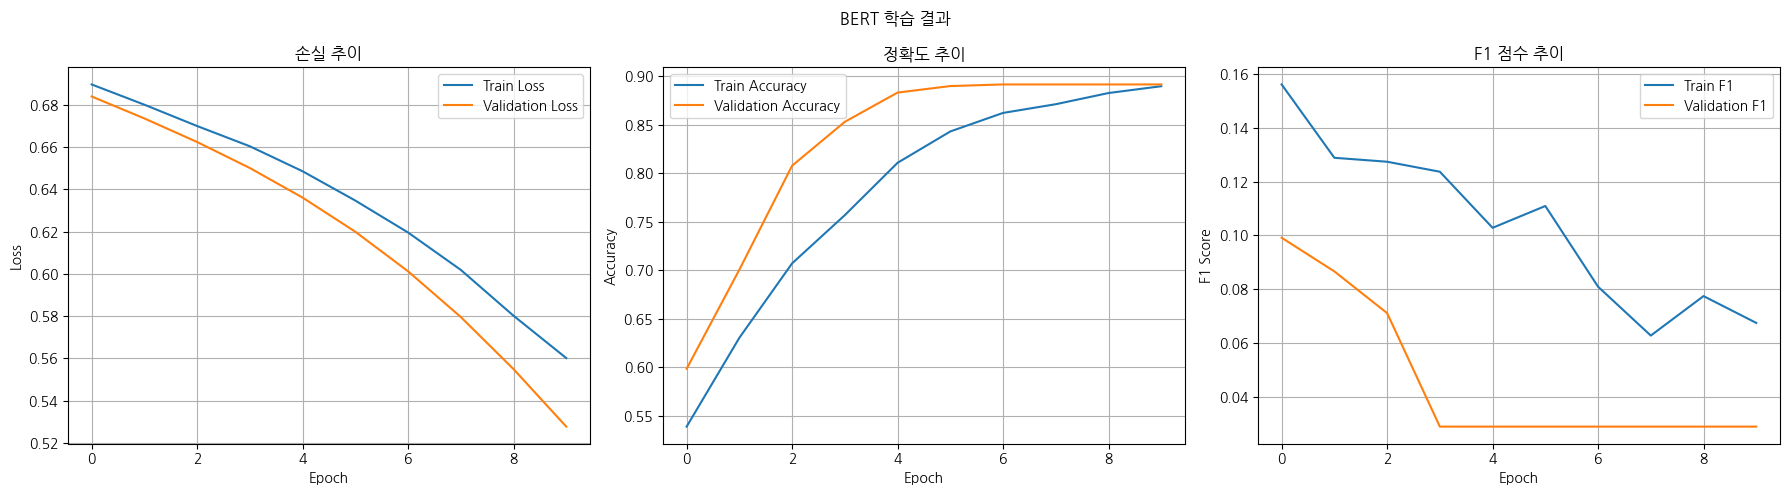

Testing:   0%|          | 0/5 [00:00<?, ?it/s]


BERT 평가 결과:
  loss: 0.5408
  accuracy: 0.8775
  precision_macro: 0.0198
  recall_macro: 0.0435
  f1_macro: 0.0272
  precision_micro: 0.4545
  recall_micro: 0.1667
  f1_micro: 0.2439
  roc_auc: nan
  mAP: 0.1752
모델 저장됨: saved_models/BERT_model_20250924_194917.pth
모델 저장됨: saved_models/BERT_model_20250924_194917.pth
메모리 정리 중...
메모리 정리 완료
BERT 학습 및 저장 완료!
[4/8] RoBERTa 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
BERT 학습 및 저장 완료!
[4/8] RoBERTa 학습 시작...
메모리 정리 중...
메모리 정리 완료


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: RoBERTa
Epoch 1/10
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: RoBERTa
Epoch 1/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6957, Val Loss: 0.6921
Train Acc: 0.4631, Val Acc: 0.4833
Train F1: 0.1445, Val F1: 0.0802
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6899, Val Loss: 0.6867
Train Acc: 0.5187, Val Acc: 0.5234
Train F1: 0.1382, Val F1: 0.0826
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6845, Val Loss: 0.6812
Train Acc: 0.5955, Val Acc: 0.7157
Train F1: 0.1169, Val F1: 0.0625
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6768, Val Loss: 0.6757
Train Acc: 0.6693, Val Acc: 0.7843
Train F1: 0.0955, Val F1: 0.0496
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6729, Val Loss: 0.6699
Train Acc: 0.7156, Val Acc: 0.8278
Train F1: 0.0917, Val F1: 0.0496
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6662, Val Loss: 0.6640
Train Acc: 0.7711, Val Acc: 0.8278
Train F1: 0.0999, Val F1: 0.0496
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6593, Val Loss: 0.6576
Train Acc: 0.8011, Val Acc: 0.8462
Train F1: 0.0827, Val F1: 0.0514
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6521, Val Loss: 0.6505
Train Acc: 0.8353, Val Acc: 0.8579
Train F1: 0.0674, Val F1: 0.0380
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6468, Val Loss: 0.6428
Train Acc: 0.8435, Val Acc: 0.8913
Train F1: 0.0651, Val F1: 0.0225
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6355, Val Loss: 0.6342
Train Acc: 0.8597, Val Acc: 0.8913
Train F1: 0.0540, Val F1: 0.0000
--------------------------------------------------


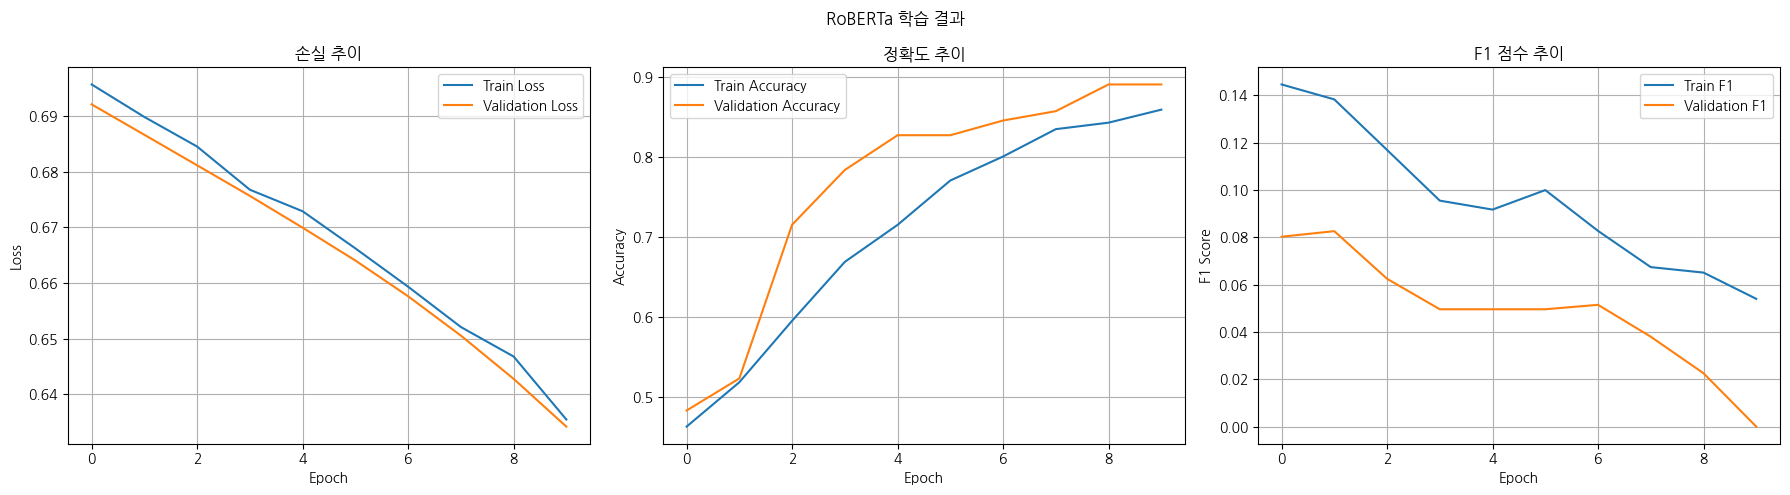

Testing:   0%|          | 0/5 [00:00<?, ?it/s]


RoBERTa 평가 결과:
  loss: 0.6369
  accuracy: 0.8814
  precision_macro: 0.0000
  recall_macro: 0.0000
  f1_macro: 0.0000
  precision_micro: 0.0000
  recall_micro: 0.0000
  f1_micro: 0.0000
  roc_auc: nan
  mAP: 0.1746
모델 저장됨: saved_models/RoBERTa_model_20250924_195844.pth
모델 저장됨: saved_models/RoBERTa_model_20250924_195844.pth
메모리 정리 중...
메모리 정리 완료
RoBERTa 학습 및 저장 완료!
[5/8] EarlyFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
RoBERTa 학습 및 저장 완료!
[5/8] EarlyFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: EarlyFusion
Epoch 1/10
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: EarlyFusion
Epoch 1/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6839, Val Loss: 0.6603
Train Acc: 0.5891, Val Acc: 0.8060
Train F1: 0.1443, Val F1: 0.0363
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6477, Val Loss: 0.6207
Train Acc: 0.8025, Val Acc: 0.8629
Train F1: 0.1110, Val F1: 0.0113
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6089, Val Loss: 0.5771
Train Acc: 0.8513, Val Acc: 0.8846
Train F1: 0.0637, Val F1: 0.0290
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5649, Val Loss: 0.5304
Train Acc: 0.8654, Val Acc: 0.8896
Train F1: 0.0474, Val F1: 0.0290
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5180, Val Loss: 0.4815
Train Acc: 0.8732, Val Acc: 0.8913
Train F1: 0.0442, Val F1: 0.0290
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4754, Val Loss: 0.4351
Train Acc: 0.8774, Val Acc: 0.8913
Train F1: 0.0435, Val F1: 0.0290
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4315, Val Loss: 0.3958
Train Acc: 0.8842, Val Acc: 0.8913
Train F1: 0.0342, Val F1: 0.0290
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3924, Val Loss: 0.3647
Train Acc: 0.8909, Val Acc: 0.8913
Train F1: 0.0305, Val F1: 0.0290
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3678, Val Loss: 0.3405
Train Acc: 0.8965, Val Acc: 0.8913
Train F1: 0.0367, Val F1: 0.0290
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3447, Val Loss: 0.3250
Train Acc: 0.8920, Val Acc: 0.8913
Train F1: 0.0258, Val F1: 0.0290
--------------------------------------------------


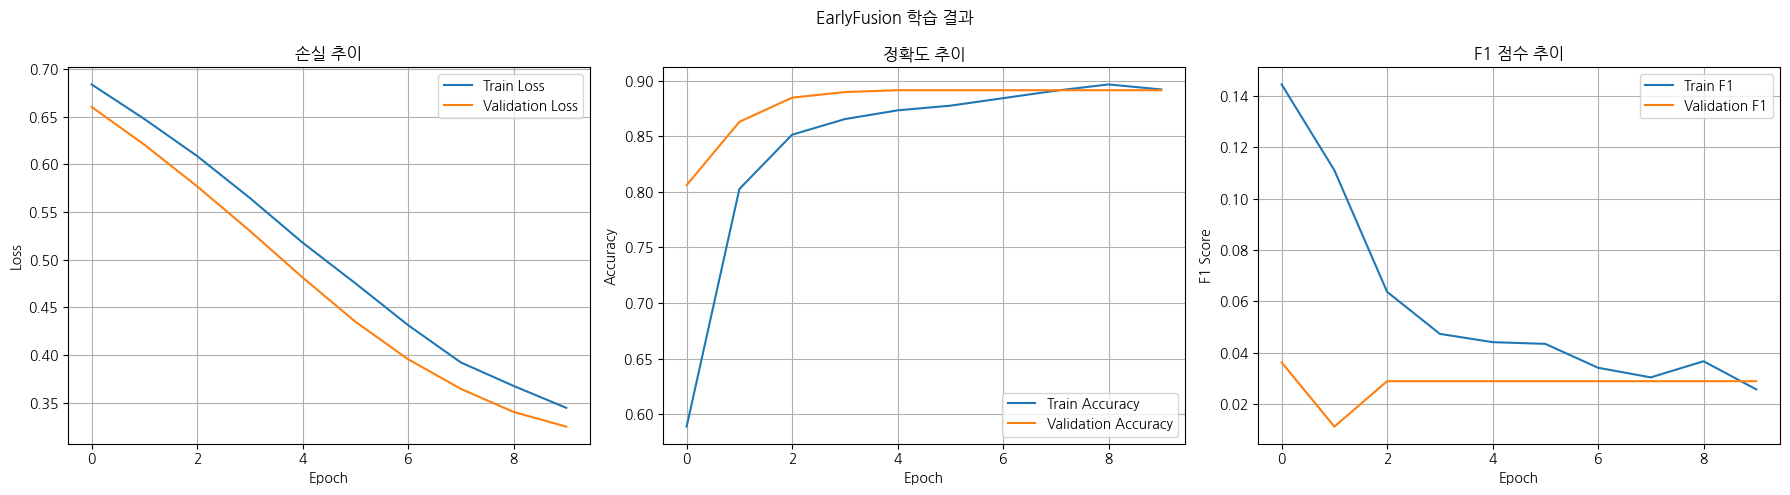

Testing:   0%|          | 0/5 [00:00<?, ?it/s]


EarlyFusion 평가 결과:
  loss: 0.3398
  accuracy: 0.8775
  precision_macro: 0.0198
  recall_macro: 0.0435
  f1_macro: 0.0272
  precision_micro: 0.4545
  recall_micro: 0.1667
  f1_micro: 0.2439
  roc_auc: nan
  mAP: 0.1717
모델 저장됨: saved_models/EarlyFusion_model_20250924_200955.pth
모델 저장됨: saved_models/EarlyFusion_model_20250924_200955.pth
메모리 정리 중...
메모리 정리 완료
EarlyFusion 학습 및 저장 완료!
[6/8] LateFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
EarlyFusion 학습 및 저장 완료!
[6/8] LateFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: LateFusion
Epoch 1/10
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: LateFusion
Epoch 1/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6697, Val Loss: 0.6406
Train Acc: 0.6519, Val Acc: 0.8612
Train F1: 0.1247, Val F1: 0.0570
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6217, Val Loss: 0.5893
Train Acc: 0.8555, Val Acc: 0.8880
Train F1: 0.0740, Val F1: 0.0130
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5729, Val Loss: 0.5416
Train Acc: 0.8892, Val Acc: 0.8880
Train F1: 0.0282, Val F1: 0.0092
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5256, Val Loss: 0.4944
Train Acc: 0.8914, Val Acc: 0.8863
Train F1: 0.0178, Val F1: 0.0048
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4807, Val Loss: 0.4521
Train Acc: 0.8959, Val Acc: 0.8880
Train F1: 0.0248, Val F1: 0.0092
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4408, Val Loss: 0.4159
Train Acc: 0.8923, Val Acc: 0.8880
Train F1: 0.0171, Val F1: 0.0092
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4076, Val Loss: 0.3874
Train Acc: 0.8917, Val Acc: 0.8846
Train F1: 0.0170, Val F1: 0.0000
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3806, Val Loss: 0.3641
Train Acc: 0.8923, Val Acc: 0.8880
Train F1: 0.0170, Val F1: 0.0092
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3602, Val Loss: 0.3468
Train Acc: 0.8951, Val Acc: 0.8880
Train F1: 0.0209, Val F1: 0.0092
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3447, Val Loss: 0.3337
Train Acc: 0.8914, Val Acc: 0.8880
Train F1: 0.0185, Val F1: 0.0051
--------------------------------------------------


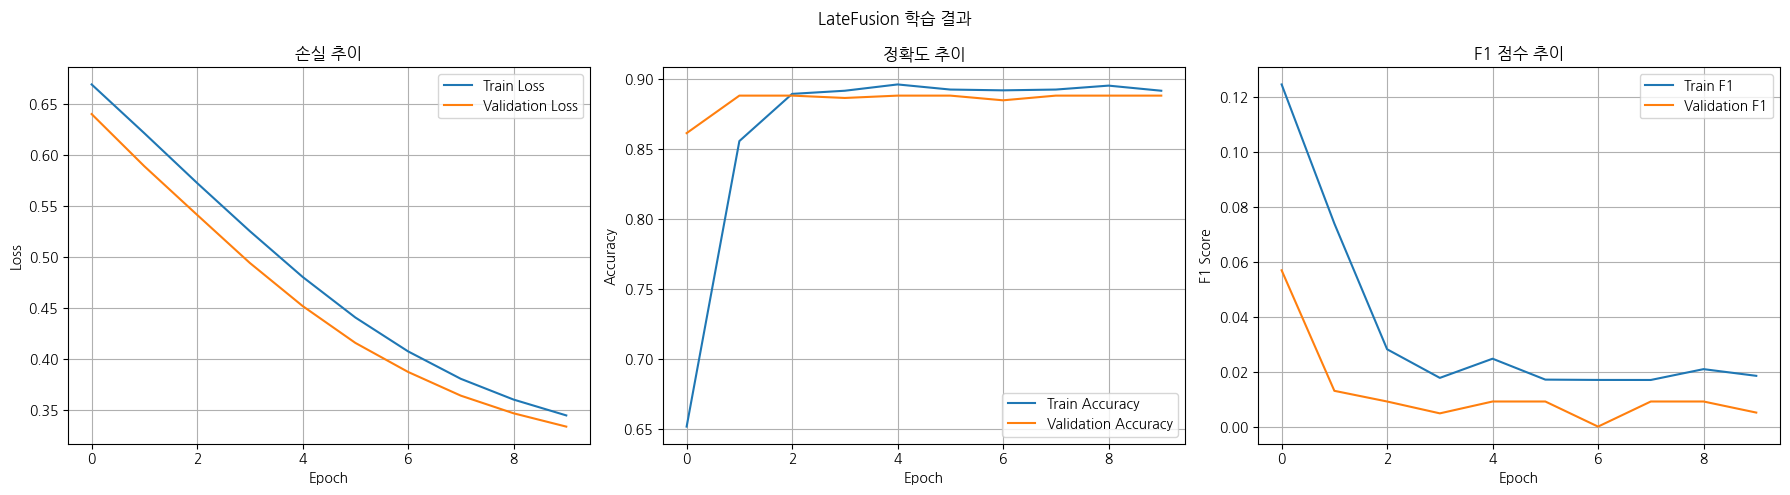

Testing:   0%|          | 0/5 [00:00<?, ?it/s]


LateFusion 평가 결과:
  loss: 0.3487
  accuracy: 0.8792
  precision_macro: 0.0072
  recall_macro: 0.0012
  f1_macro: 0.0021
  precision_micro: 0.1667
  recall_micro: 0.0048
  f1_micro: 0.0093
  roc_auc: nan
  mAP: 0.1699
모델 저장됨: saved_models/LateFusion_model_20250924_202106.pth
모델 저장됨: saved_models/LateFusion_model_20250924_202106.pth
메모리 정리 중...
메모리 정리 완료
LateFusion 학습 및 저장 완료!
[7/8] AttentionFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
LateFusion 학습 및 저장 완료!
[7/8] AttentionFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: AttentionFusion
Epoch 1/10
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: AttentionFusion
Epoch 1/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6896, Val Loss: 0.6799
Train Acc: 0.5433, Val Acc: 0.6104
Train F1: 0.1387, Val F1: 0.1026
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6728, Val Loss: 0.6584
Train Acc: 0.7069, Val Acc: 0.8211
Train F1: 0.1117, Val F1: 0.0634
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6483, Val Loss: 0.6244
Train Acc: 0.7978, Val Acc: 0.8478
Train F1: 0.0825, Val F1: 0.0580
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6076, Val Loss: 0.5715
Train Acc: 0.8373, Val Acc: 0.8796
Train F1: 0.0750, Val F1: 0.0580
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5491, Val Loss: 0.5070
Train Acc: 0.8665, Val Acc: 0.8913
Train F1: 0.0702, Val F1: 0.0572
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4861, Val Loss: 0.4426
Train Acc: 0.8746, Val Acc: 0.8913
Train F1: 0.0529, Val F1: 0.0290
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4282, Val Loss: 0.3889
Train Acc: 0.8847, Val Acc: 0.8913
Train F1: 0.0461, Val F1: 0.0290
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3782, Val Loss: 0.3516
Train Acc: 0.8923, Val Acc: 0.8913
Train F1: 0.0499, Val F1: 0.0290
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3526, Val Loss: 0.3304
Train Acc: 0.8853, Val Acc: 0.8913
Train F1: 0.0326, Val F1: 0.0290
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3303, Val Loss: 0.3206
Train Acc: 0.8889, Val Acc: 0.8913
Train F1: 0.0299, Val F1: 0.0290
--------------------------------------------------


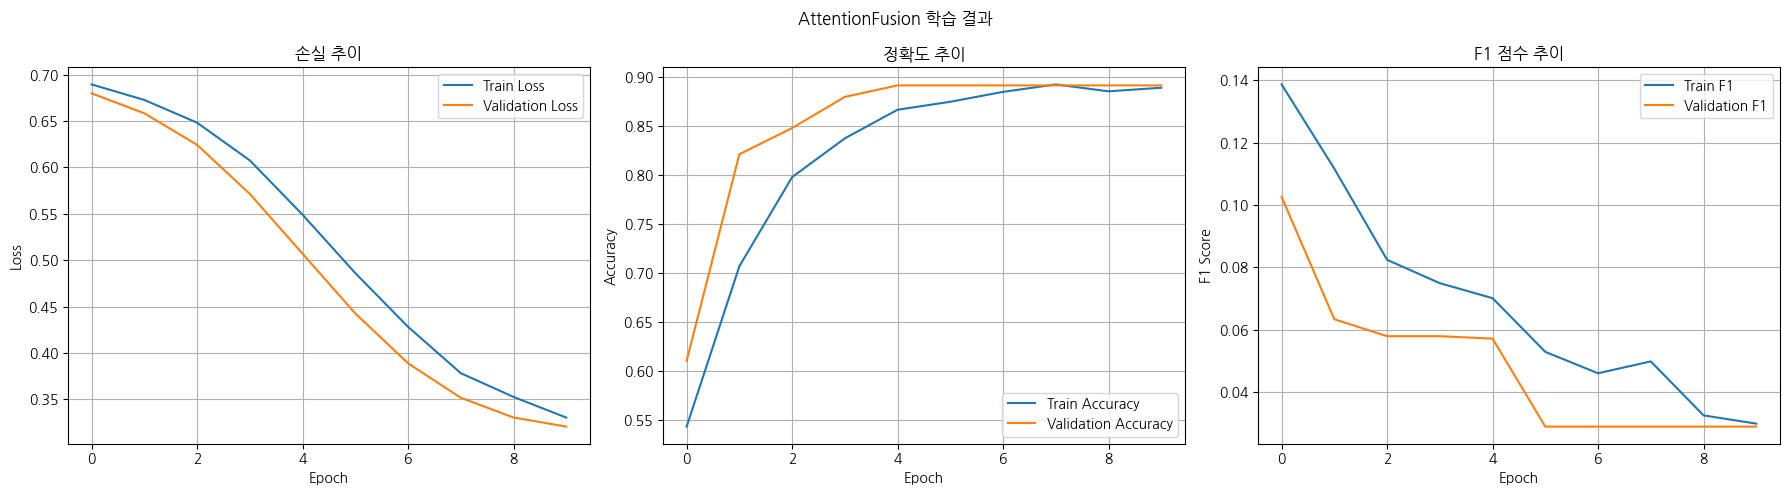

Testing:   0%|          | 0/5 [00:00<?, ?it/s]


AttentionFusion 평가 결과:
  loss: 0.3455
  accuracy: 0.8775
  precision_macro: 0.0198
  recall_macro: 0.0435
  f1_macro: 0.0272
  precision_micro: 0.4545
  recall_micro: 0.1667
  f1_micro: 0.2439
  roc_auc: nan
  mAP: 0.1746
모델 저장됨: saved_models/AttentionFusion_model_20250924_203215.pth
모델 저장됨: saved_models/AttentionFusion_model_20250924_203215.pth
메모리 정리 중...
메모리 정리 완료
AttentionFusion 학습 및 저장 완료!
[8/8] CrossAttentionFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
AttentionFusion 학습 및 저장 완료!
[8/8] CrossAttentionFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: CrossAttentionFusion
Epoch 1/10
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: CrossAttentionFusion
Epoch 1/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6666, Val Loss: 0.6285
Train Acc: 0.6286, Val Acc: 0.7742
Train F1: 0.1514, Val F1: 0.0703
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6066, Val Loss: 0.5691
Train Acc: 0.7647, Val Acc: 0.7926
Train F1: 0.0990, Val F1: 0.0256
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5519, Val Loss: 0.5167
Train Acc: 0.8095, Val Acc: 0.8562
Train F1: 0.0832, Val F1: 0.0090
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5007, Val Loss: 0.4704
Train Acc: 0.8466, Val Acc: 0.8595
Train F1: 0.1099, Val F1: 0.0093
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4611, Val Loss: 0.4298
Train Acc: 0.8620, Val Acc: 0.8896
Train F1: 0.0763, Val F1: 0.0000
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4264, Val Loss: 0.3952
Train Acc: 0.8679, Val Acc: 0.8913
Train F1: 0.0553, Val F1: 0.0000
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3914, Val Loss: 0.3668
Train Acc: 0.8774, Val Acc: 0.8930
Train F1: 0.0489, Val F1: 0.0109
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3674, Val Loss: 0.3445
Train Acc: 0.8867, Val Acc: 0.8913
Train F1: 0.0390, Val F1: 0.0264
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3471, Val Loss: 0.3273
Train Acc: 0.8914, Val Acc: 0.8913
Train F1: 0.0430, Val F1: 0.0273
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3310, Val Loss: 0.3153
Train Acc: 0.8875, Val Acc: 0.8946
Train F1: 0.0317, Val F1: 0.0207
--------------------------------------------------


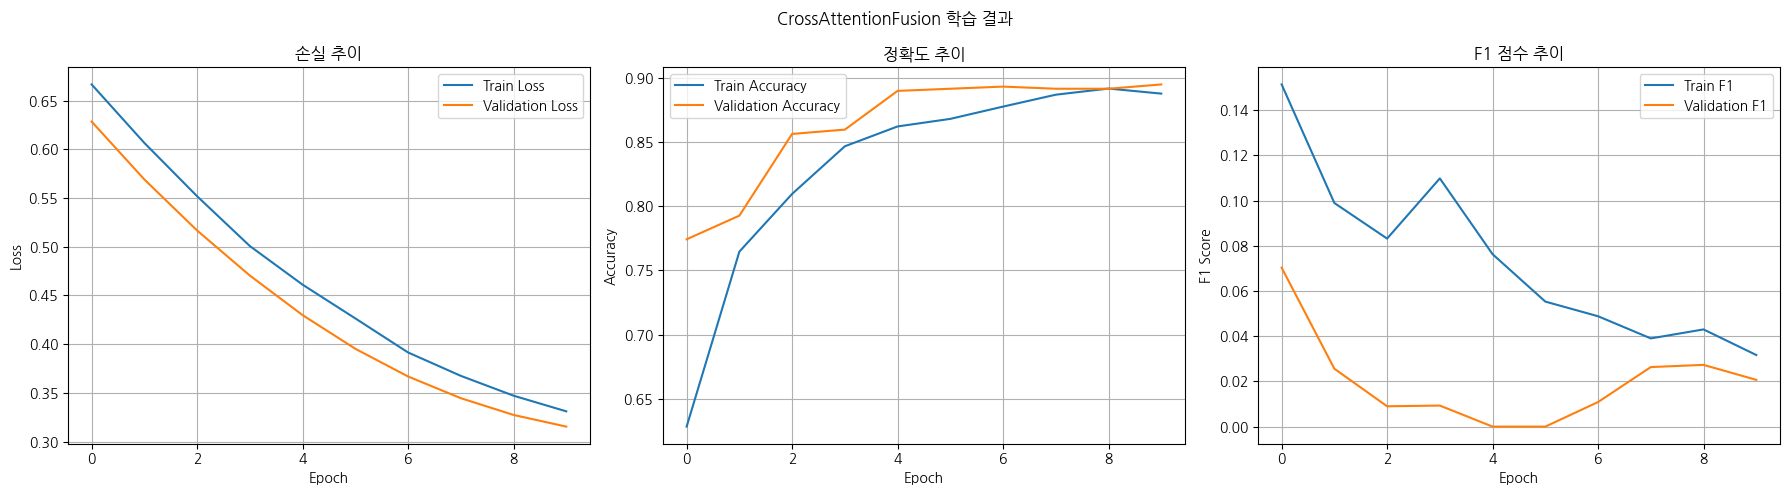

Testing:   0%|          | 0/5 [00:00<?, ?it/s]


CrossAttentionFusion 평가 결과:
  loss: 0.3342
  accuracy: 0.8837
  precision_macro: 0.0266
  recall_macro: 0.0137
  f1_macro: 0.0180
  precision_micro: 0.6111
  recall_micro: 0.0524
  f1_micro: 0.0965
  roc_auc: nan
  mAP: 0.1985
모델 저장됨: saved_models/CrossAttentionFusion_model_20250924_204328.pth
모델 저장됨: saved_models/CrossAttentionFusion_model_20250924_204328.pth
메모리 정리 중...
메모리 정리 완료
CrossAttentionFusion 학습 및 저장 완료!

🎉 모든 모델 학습 완료!
메모리 정리 중...
메모리 정리 완료
CrossAttentionFusion 학습 및 저장 완료!

🎉 모든 모델 학습 완료!


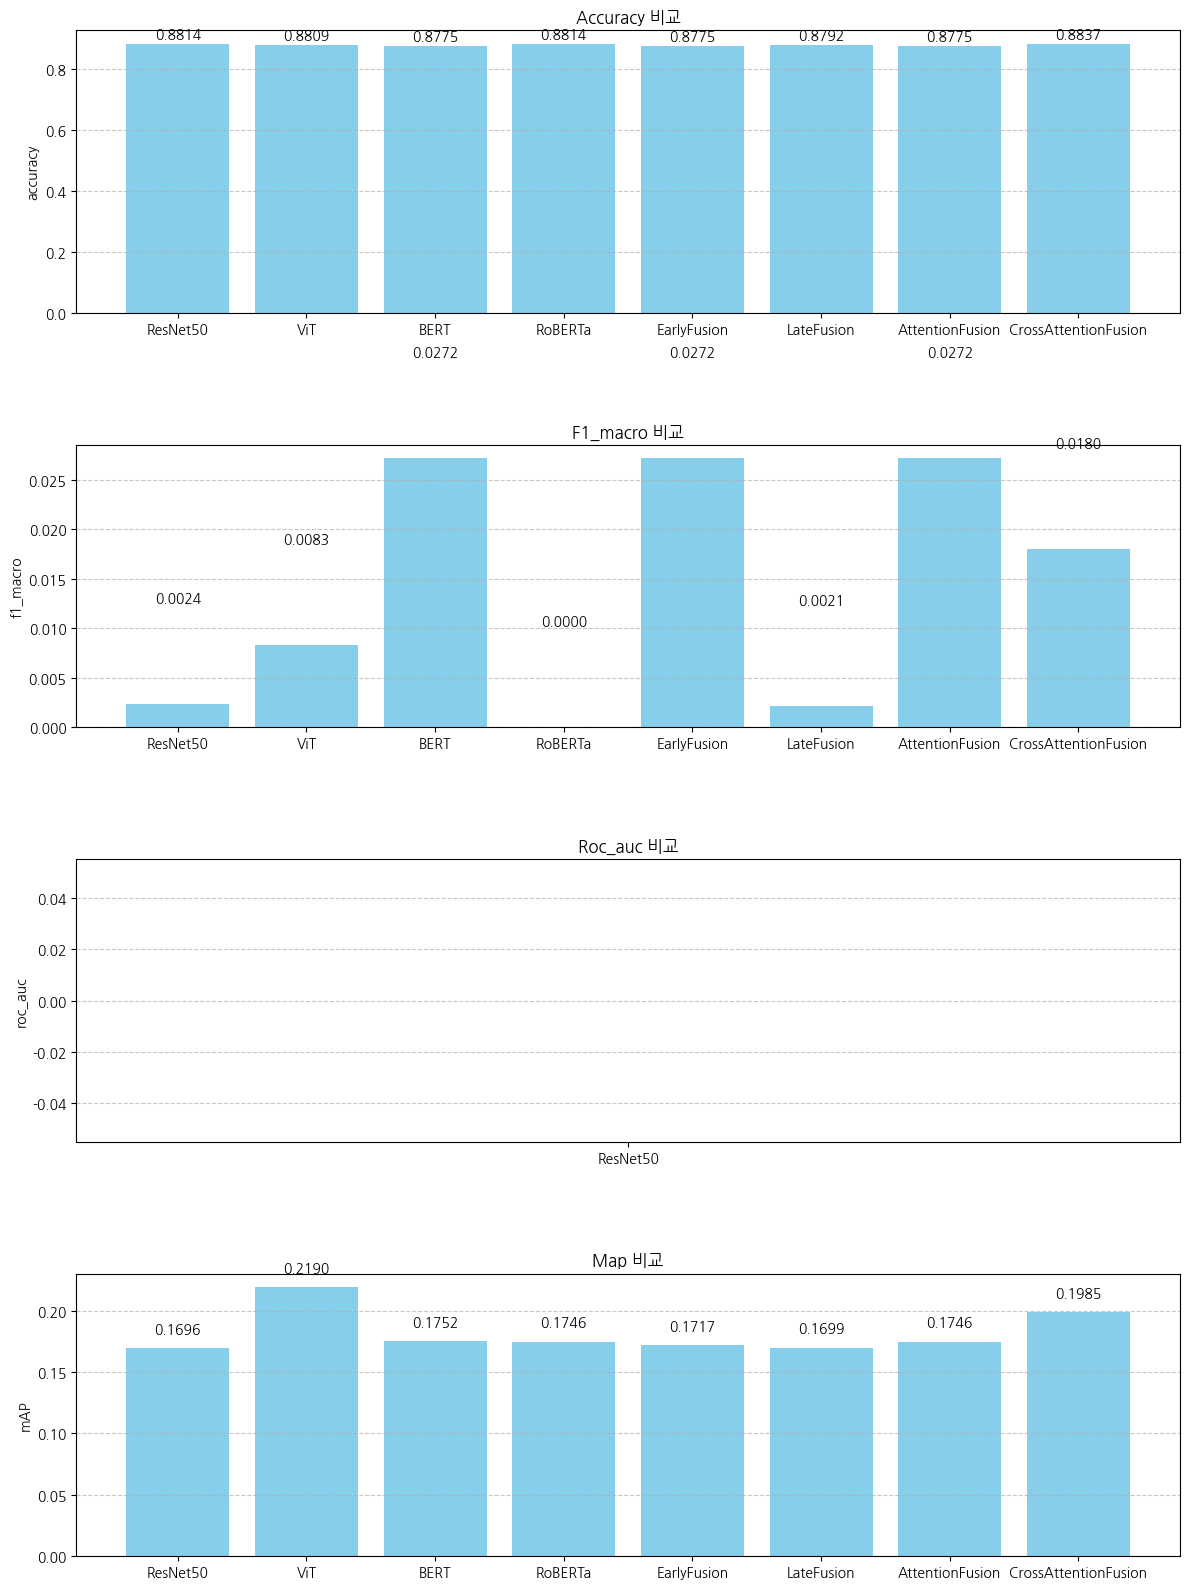


🏆 Best model: BERT
   F1-macro score: 0.0272
모델 결과 저장됨: saved_models/model_results_20250924_204330.pkl
학습 변수들 저장됨: saved_models/comprehensive_training_variables.pkl

📊 최종 결과 요약:
- 총 시도한 모델 수: 8
- 성공한 모델 수: 8
- 실패한 모델 수: 0

📈 성공한 모델들의 F1-macro 점수:
  ResNet50: 0.0024
  ViT: 0.0083
  BERT: 0.0272
  RoBERTa: 0.0000
  EarlyFusion: 0.0272
  LateFusion: 0.0021
  AttentionFusion: 0.0272
  CrossAttentionFusion: 0.0180


In [15]:
# 메모리 효율적인 실험 설정 및 모델 학습

import os
import torch
import pickle
from datetime import datetime

# 모델 저장 디렉토리 생성
os.makedirs('saved_models', exist_ok=True)

# 손실 함수 정의 (멀티 레이블 분류)
criterion = nn.BCEWithLogitsLoss()

# 학습 파라미터
num_epochs = 10
learning_rate = 2e-5
weight_decay = 1e-4

# 모델 결과 저장을 위한 딕셔너리
model_results = {}

# 학습할 모델 정의 (한 번에 하나씩 생성하여 메모리 절약)
models_config = {
    # 단일 모달 모델
    'ResNet50': {'type': 'single', 'modality': 'image', 'extractor': 'resnet50'},
    'ViT': {'type': 'single', 'modality': 'image', 'extractor': 'vit'},
    'BERT': {'type': 'single', 'modality': 'text', 'extractor': 'bert'},
    'RoBERTa': {'type': 'single', 'modality': 'text', 'extractor': 'roberta'},
    
    # 멀티모달 모델
    'EarlyFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'early'},
    'LateFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'late'},
    'AttentionFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'attention'},
    'CrossAttentionFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'cross-attention'}
}

print(f"총 {len(models_config)}개의 모델을 순차적으로 학습합니다.")
print("각 모델 학습 후 메모리를 정리하여 OutOfMemory 오류를 방지합니다.\n")

# 각 모델을 순차적으로 학습 (메모리 효율성을 위해)
for i, (model_name, config) in enumerate(models_config.items(), 1):
    print(f"[{i}/{len(models_config)}] {model_name} 학습 시작...")
    
    # 이전 모델 변수들 정리
    if 'model' in locals():
        del model
    if 'optimizer' in locals():
        del optimizer
    if 'scheduler' in locals():
        del scheduler
    
    # 메모리 정리
    clear_memory()
    
    try:
        # 모델 생성
        if config['type'] == 'single':
            model = SingleModalModel(
                len(genre_list), 
                modality=config['modality'], 
                extractor=config['extractor']
            )
        else:  # multi
            model = MultimodalModel(
                len(genre_list),
                img_extractor=config['img_extractor'],
                text_extractor=config['text_extractor'],
                fusion_method=config['fusion_method']
            )
        
        # 모델을 안전하게 디바이스로 이동
        model = safe_model_to_device(model, device)
        
        # 옵티마이저 정의
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        # 학습률 스케줄러
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2
        )
        
        print(f"모델 학습 시작: {model_name}")
        
        # 모델 학습
        model, history = train_model(
            model, train_loader, val_loader,
            criterion, optimizer, scheduler,
            num_epochs=num_epochs, device=device
        )
        
        # 학습 과정 시각화
        plot_training_history(history, title=f'{model_name} 학습 결과')
        
        # 테스트 세트에서 모델 평가
        metrics, preds, probs, targets = evaluate_model(model, test_loader, criterion, device)
        
        # 결과 출력
        print(f"\n{model_name} 평가 결과:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # 결과 저장
        model_results[model_name] = metrics
        
        # 모델 저장
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_save_path = f'saved_models/{model_name}_model_{timestamp}.pth'
        
        # 모델 설정 정보 생성
        if config['type'] == 'single':
            model_config = {
                'model_name': model_name,
                'type': 'single_modal',
                'num_classes': len(genre_list),
                'modality': config['modality'],
                'extractor': config['extractor'],
                'genre_list': genre_list,
                'genre_to_idx': genre_to_idx,
                'idx_to_genre': idx_to_genre
            }
        else:
            model_config = {
                'model_name': model_name,
                'type': 'multimodal',
                'num_classes': len(genre_list),
                'img_extractor': config['img_extractor'],
                'text_extractor': config['text_extractor'],
                'fusion_method': config['fusion_method'],
                'freeze_extractors': False,
                'genre_list': genre_list,
                'genre_to_idx': genre_to_idx,
                'idx_to_genre': idx_to_genre
            }
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_config': model_config,
            'metrics': metrics,
            'history': history,
            'num_epochs': num_epochs,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'predictions': preds,
            'probabilities': probs,
            'targets': targets
        }, model_save_path)
        
        print(f"모델 저장됨: {model_save_path}")
        
        # 모델을 CPU로 이동하여 GPU 메모리 해제
        model = model.cpu()
        
        # 메모리 정리
        clear_memory()
        
        print(f"{model_name} 학습 및 저장 완료!")
        print("=" * 60)
        
    except Exception as e:
        print(f"❌ {model_name} 학습 중 오류 발생: {e}")
        
        # 오류 발생 시에도 메모리 정리
        if 'model' in locals():
            model = model.cpu()
        clear_memory()
        
        # 오류를 기록하지만 다음 모델 학습을 계속 진행
        model_results[model_name] = {'error': str(e)}
        print(f"다음 모델로 계속 진행합니다...")
        print("=" * 60)
        continue

print("\n🎉 모든 모델 학습 완료!")

# 성공적으로 학습된 모델들만 필터링
successful_results = {k: v for k, v in model_results.items() if 'error' not in v}

if successful_results:
    # 모델 비교 시각화 (성공한 모델들만)
    plot_model_comparison(successful_results)
    
    # 가장 성능이 좋은 모델 선택 (F1 점수 기준)
    best_model_name = max(successful_results, key=lambda k: successful_results[k]['f1_macro'])
    print(f"\n🏆 Best model: {best_model_name}")
    print(f"   F1-macro score: {successful_results[best_model_name]['f1_macro']:.4f}")
else:
    print("❌ 성공적으로 학습된 모델이 없습니다.")
    best_model_name = None

# 모델 결과를 파일로 저장
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_save_path = f'saved_models/model_results_{timestamp}.pkl'
with open(results_save_path, 'wb') as f:
    pickle.dump(model_results, f)
print(f"모델 결과 저장됨: {results_save_path}")

# 주요 변수들을 pickle 파일로 저장 (Cell 25에서 로드하기 위해)
training_variables = {
    'model_results': model_results,
    'successful_results': successful_results,
    'best_model_name': best_model_name,
    'timestamp': timestamp,
    'criterion': criterion,
    'train_loader': train_loader,
    'val_loader': val_loader,
    'test_loader': test_loader,
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'device': device,
    'genre_list': genre_list,
    'genre_to_idx': genre_to_idx,
    'idx_to_genre': idx_to_genre,
    'models_config': models_config
}

training_variables_path = 'saved_models/comprehensive_training_variables.pkl'
with open(training_variables_path, 'wb') as f:
    pickle.dump(training_variables, f)
print(f"학습 변수들 저장됨: {training_variables_path}")

print(f"\n📊 최종 결과 요약:")
print(f"- 총 시도한 모델 수: {len(models_config)}")
print(f"- 성공한 모델 수: {len(successful_results)}")
print(f"- 실패한 모델 수: {len(models_config) - len(successful_results)}")

if successful_results:
    print(f"\n📈 성공한 모델들의 F1-macro 점수:")
    for model_name, metrics in successful_results.items():
        print(f"  {model_name}: {metrics['f1_macro']:.4f}")

Epoch 1/1


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/1


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/1


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.7952, Val Loss: 0.3095
Train Acc: 0.8139, Val Acc: 0.8921
Train F1: 0.0979, Val F1: 0.0000
--------------------------------------------------


Epoch 1/1


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.7952, Val Loss: 0.3095
Train Acc: 0.8139, Val Acc: 0.8921
Train F1: 0.0979, Val F1: 0.0000
--------------------------------------------------


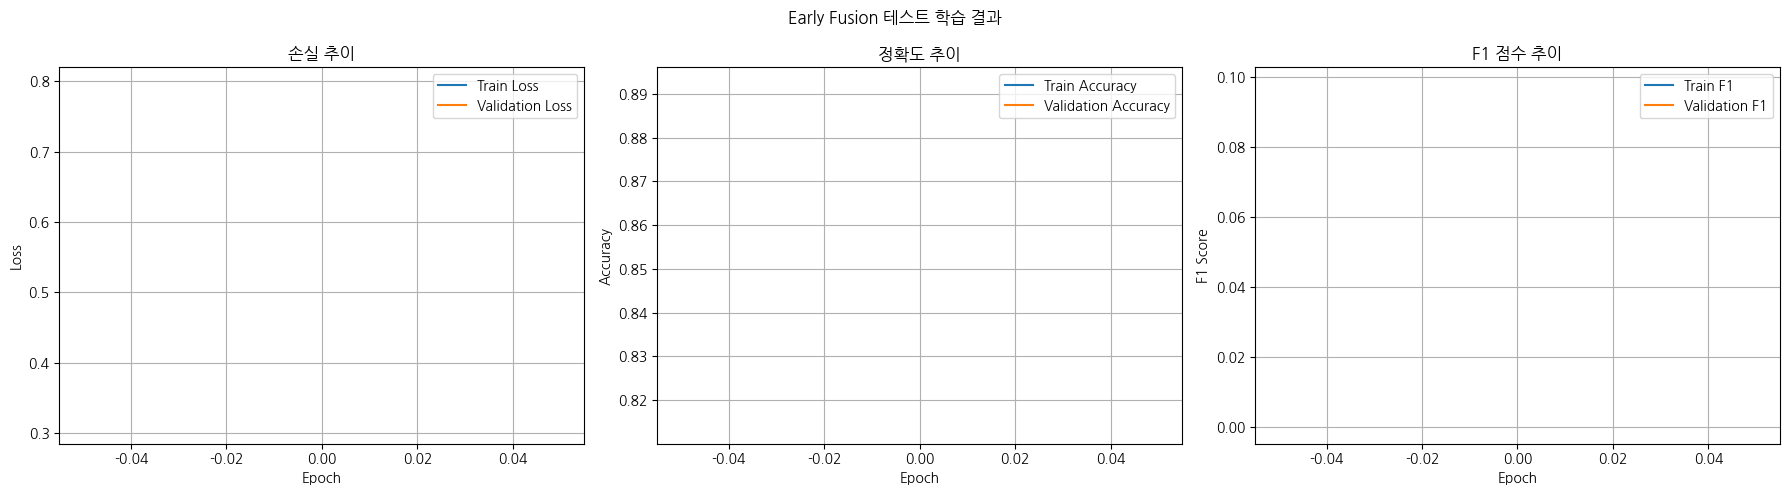

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/1


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.7952, Val Loss: 0.3095
Train Acc: 0.8139, Val Acc: 0.8921
Train F1: 0.0979, Val F1: 0.0000
--------------------------------------------------


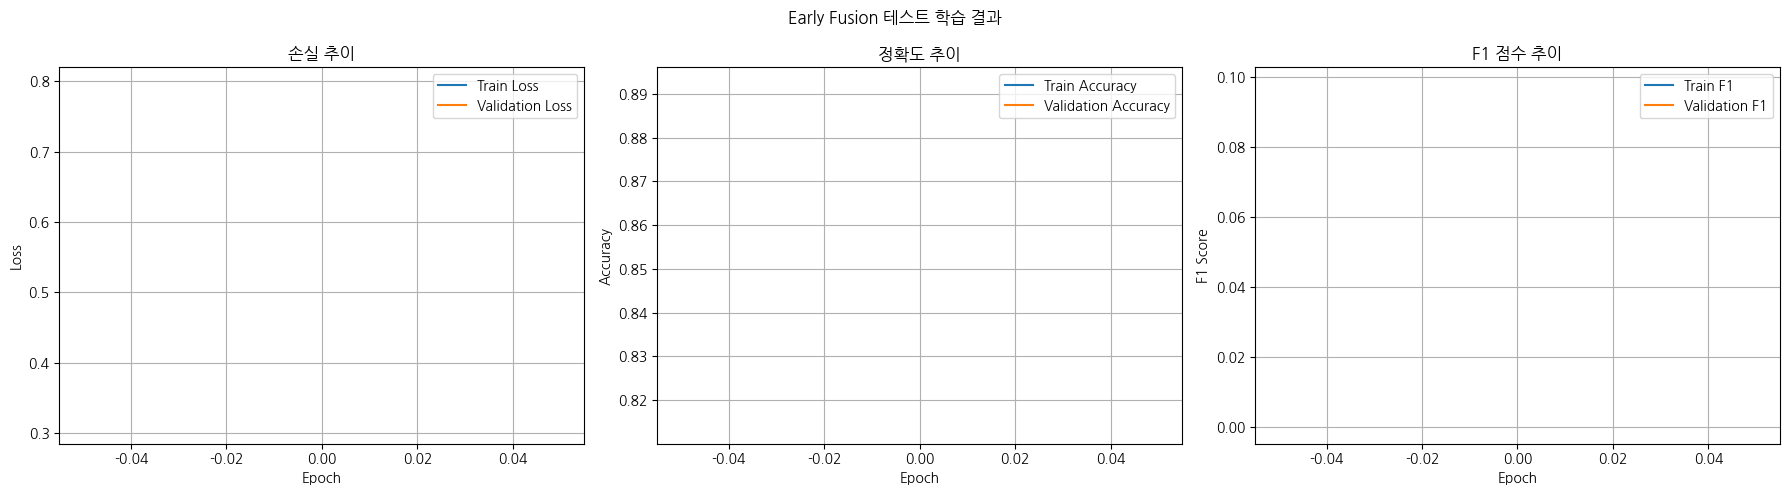

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Mini model 평가 결과:
loss: 0.3115
accuracy: 0.8923
precision_macro: 0.0000
recall_macro: 0.0000
f1_macro: 0.0000
precision_micro: 0.0000
recall_micro: 0.0000
f1_micro: 0.0000
roc_auc: 0.4988
mAP: 0.1390
Mini 모델 저장됨: saved_models/mini_EarlyFusion_model_20250924_175802.pth
Mini 모델 저장됨: saved_models/mini_EarlyFusion_model_20250924_175802.pth
학습 변수들이 저장됨: saved_models/training_variables.pkl
학습 변수들이 저장됨: saved_models/training_variables.pkl


In [14]:
# 간소화된 예시: 빠른 테스트를 위한 작은 모델 훈련 (실제 실행 가능)

import os
import torch
import pickle
from datetime import datetime

# 모델 저장 디렉토리 생성
os.makedirs('saved_models', exist_ok=True)

# 더 빠른 훈련을 위한 배치 사이즈 및 워커 수 조정
mini_batch_size = 32  # 배치 사이즈 증가로 처리 속도 향상

mini_train_loader = DataLoader(
    train_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0  # 워커 수 감소로 오버헤드 최소화
)

mini_val_loader = DataLoader(
    val_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=0
)

mini_test_loader = DataLoader(
    test_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=0
)

# 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# 간소화된 학습 파라미터
mini_epochs = 1
learning_rate = 1e-2

# 간단한 모델 테스트 (Early Fusion)
mini_model = MultimodalModel(
    len(genre_list), 
    img_extractor='resnet50', 
    text_extractor='bert', 
    fusion_method='early', 
    freeze_extractors=True  # 특징 추출기 고정으로 빠른 학습
).to(device)

# 옵티마이저 정의
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, mini_model.parameters()),
    lr=learning_rate
)

# 학습 실행
mini_model, mini_history = train_model(
    mini_model, mini_train_loader, mini_val_loader,
    criterion, optimizer, scheduler=None,
    num_epochs=mini_epochs, device=device
)

# 학습 과정 시각화
plot_training_history(mini_history, title='Early Fusion 테스트 학습 결과')

# 테스트 세트에서 모델 평가
mini_metrics, mini_preds, mini_probs, mini_targets = evaluate_model(mini_model, mini_test_loader, criterion, device)

# 결과 출력
print("Mini model 평가 결과:")
for metric, value in mini_metrics.items():
    print(f"{metric}: {value:.4f}")

# 모델 저장
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
mini_model_save_path = f'saved_models/mini_EarlyFusion_model_{timestamp}.pth'
torch.save({
    'model_state_dict': mini_model.state_dict(),
    'model_config': {
        'model_name': 'EarlyFusion',
        'num_classes': len(genre_list),
        'genre_list': genre_list,
        'genre_to_idx': genre_to_idx,
        'idx_to_genre': idx_to_genre,
        'img_extractor': 'resnet50',
        'text_extractor': 'bert',
        'fusion_method': 'early',
        'freeze_extractors': True
    },
    'metrics': mini_metrics,
    'history': mini_history,
    'num_epochs': mini_epochs,
    'learning_rate': learning_rate,
    'predictions': mini_preds,
    'probabilities': mini_probs,
    'targets': mini_targets
}, mini_model_save_path)

print(f"Mini 모델 저장됨: {mini_model_save_path}")

# 변수들을 pickle 파일로 저장 (학습 변수 저장)
training_variables = {
    'mini_model': mini_model,
    'mini_history': mini_history,
    'mini_test_loader': mini_test_loader,
    'mini_train_loader': mini_train_loader,
    'mini_val_loader': mini_val_loader,
    'criterion': criterion,
    'mini_metrics': mini_metrics,
    'mini_preds': mini_preds,
    'mini_probs': mini_probs,
    'mini_targets': mini_targets,
    'mini_batch_size': mini_batch_size,
    'mini_epochs': mini_epochs,
    'learning_rate': learning_rate
}

training_vars_path = 'saved_models/training_variables.pkl'
with open(training_vars_path, 'wb') as f:
    pickle.dump(training_variables, f)

print(f"학습 변수들이 저장됨: {training_vars_path}")

## 저장된 모델 불러오기 및 사용

In [15]:
# 저장된 모델을 불러오는 함수
def load_saved_model(model_path, device):
    """
    저장된 모델을 불러오는 함수
    
    Args:
        model_path (str): 저장된 모델 파일 경로
        device: PyTorch 디바이스
    
    Returns:
        tuple: (model, model_info)
    """
    # 저장된 데이터 로드 (PyTorch 2.6 호환성을 위해 weights_only=False 설정)
    try:
        # 먼저 weights_only=True로 시도
        checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    except Exception as e:
        print(f"weights_only=True로 로딩 실패, weights_only=False로 재시도...")
        # 실패하면 weights_only=False로 재시도 (신뢰할 수 있는 파일인 경우)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # 모델 설정 정보 추출
    model_config = checkpoint['model_config']
    model_name = model_config['model_name']
    
    print(f"모델 정보:")
    print(f"- 모델 이름: {model_name}")
    print(f"- 클래스 수: {model_config['num_classes']}")
    
    # 모델 재생성
    if model_name in ['ResNet50', 'ViT']:
        # 이미지 단일 모달 모델
        model = SingleModalModel(
            model_config['num_classes'], 
            modality='image', 
            extractor=model_name.lower()
        )
    elif model_name in ['BERT', 'RoBERTa']:
        # 텍스트 단일 모달 모델
        model = SingleModalModel(
            model_config['num_classes'], 
            modality='text', 
            extractor=model_name.lower()
        )
    else:
        # 멀티모달 모델
        img_extractor = model_config.get('img_extractor', 'resnet50')
        text_extractor = model_config.get('text_extractor', 'bert')
        fusion_method = model_config.get('fusion_method', 'early')
        freeze_extractors = model_config.get('freeze_extractors', False)
        
        model = MultimodalModel(
            model_config['num_classes'],
            img_extractor=img_extractor,
            text_extractor=text_extractor,
            fusion_method=fusion_method,
            freeze_extractors=freeze_extractors
        )
    
    # 모델을 디바이스로 이동
    model = model.to(device)
    
    # 저장된 가중치 로드
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # 평가 모드로 설정
    model.eval()
    
    # 모델 정보 구성
    model_info = {
        'model_name': model_name,
        'config': model_config,
        'metrics': checkpoint.get('metrics', {}),
        'history': checkpoint.get('history', {}),
        'training_params': {
            'num_epochs': checkpoint.get('num_epochs', 'N/A'),
            'learning_rate': checkpoint.get('learning_rate', 'N/A'),
            'weight_decay': checkpoint.get('weight_decay', 'N/A')
        }
    }
    
    print(f"모델이 성공적으로 로드되었습니다!")
    
    # 성능 메트릭 출력
    if 'metrics' in checkpoint and checkpoint['metrics']:
        print(f"\n저장된 모델 성능:")
        for metric, value in checkpoint['metrics'].items():
            print(f"- {metric}: {value:.4f}")
    
    return model, model_info

# Cell 22 또는 Cell 23에서 저장된 학습 변수들을 로드
# 우선 Cell 22의 포괄적 학습 변수들을 확인
comprehensive_vars_path = 'saved_models/comprehensive_training_variables.pkl'
mini_vars_path = 'saved_models/training_variables.pkl'

# Cell 22의 포괄적 변수들이 있는 경우 먼저 로드
if os.path.exists(comprehensive_vars_path):
    try:
        with open(comprehensive_vars_path, 'rb') as f:
            comprehensive_variables = pickle.load(f)
        
        # Cell 22에서 저장된 변수들을 전역 네임스페이스에 로드
        model_results = comprehensive_variables.get('model_results', {})
        best_model_name = comprehensive_variables.get('best_model_name')
        criterion = comprehensive_variables.get('criterion')
        train_loader = comprehensive_variables.get('train_loader')
        val_loader = comprehensive_variables.get('val_loader')
        test_loader = comprehensive_variables.get('test_loader')
        num_epochs = comprehensive_variables.get('num_epochs')
        learning_rate = comprehensive_variables.get('learning_rate')
        weight_decay = comprehensive_variables.get('weight_decay')
        device = comprehensive_variables.get('device')
        genre_list = comprehensive_variables.get('genre_list')
        genre_to_idx = comprehensive_variables.get('genre_to_idx')
        idx_to_genre = comprehensive_variables.get('idx_to_genre')
        models_to_train = comprehensive_variables.get('models_to_train')
        
        print(f"Cell 22의 포괄적 학습 변수들을 성공적으로 로드했습니다: {comprehensive_vars_path}")
    except Exception as e:
        print(f"포괄적 학습 변수 로드 중 오류 발생: {e}")

# Cell 23에서 저장된 미니 학습 변수들을 로드 (Cell 23을 실행하지 않고도 변수 사용 가능)
if os.path.exists(mini_vars_path):
    try:
        with open(mini_vars_path, 'rb') as f:
            training_variables = pickle.load(f)
        
        # 변수들을 전역 네임스페이스에 로드
        mini_model = training_variables.get('mini_model')
        mini_history = training_variables.get('mini_history', {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []})
        mini_test_loader = training_variables.get('mini_test_loader')
        mini_train_loader = training_variables.get('mini_train_loader')
        mini_val_loader = training_variables.get('mini_val_loader')
        criterion = training_variables.get('criterion')
        mini_metrics = training_variables.get('mini_metrics', {})
        mini_preds = training_variables.get('mini_preds')
        mini_probs = training_variables.get('mini_probs')
        mini_targets = training_variables.get('mini_targets')
        mini_batch_size = training_variables.get('mini_batch_size', 4)
        mini_epochs = training_variables.get('mini_epochs', 2)
        learning_rate = training_variables.get('learning_rate', 1e-4)
        
        print(f"Cell 23의 학습 변수들을 성공적으로 로드했습니다: {mini_vars_path}")
    except Exception as e:
        print(f"학습 변수 로드 중 오류 발생: {e}")
        print("Cell 23을 먼저 실행하여 변수들을 생성하세요.")
        # 기본값 설정
        mini_model = None
        mini_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        mini_test_loader = None
        mini_train_loader = None
        mini_val_loader = None
        criterion = nn.BCEWithLogitsLoss() if 'nn' in globals() else None
        mini_metrics = {}
        mini_preds = None
        mini_probs = None
        mini_targets = None
        mini_batch_size = 4
        mini_epochs = 2
        learning_rate = 1e-4
else:
    print("학습 변수 파일이 존재하지 않습니다. 저장된 모델에서 변수들을 재구성합니다.")
    
    # 저장된 모델 파일에서 변수들을 재구성
    model_files = glob.glob('saved_models/*.pth')
    if model_files:
        # 가장 최근 모델 파일 선택
        latest_model_file = max(model_files, key=os.path.getctime)
        print(f"최근 모델 파일에서 변수 재구성: {latest_model_file}")
        
        try:
            # 모델 파일에서 정보 로드
            checkpoint = torch.load(latest_model_file, map_location=device, weights_only=False)
            
            # 모델 재구성
            model_config = checkpoint['model_config']
            mini_model = MultimodalModel(
                model_config['num_classes'],
                img_extractor=model_config.get('img_extractor', 'resnet50'),
                text_extractor=model_config.get('text_extractor', 'bert'),
                fusion_method=model_config.get('fusion_method', 'early'),
                freeze_extractors=model_config.get('freeze_extractors', True)
            ).to(device)
            mini_model.load_state_dict(checkpoint['model_state_dict'])
            mini_model.eval()
            
            # 저장된 정보에서 변수들 추출
            mini_history = checkpoint.get('history', {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []})
            mini_metrics = checkpoint.get('metrics', {})
            mini_preds = checkpoint.get('predictions')
            mini_probs = checkpoint.get('probabilities')
            mini_targets = checkpoint.get('targets')
            mini_epochs = checkpoint.get('num_epochs', 2)
            learning_rate = checkpoint.get('learning_rate', 1e-4)
            
            print("저장된 모델에서 변수들을 성공적으로 재구성했습니다.")
            
        except Exception as e:
            print(f"모델 파일에서 변수 재구성 중 오류 발생: {e}")
            mini_model = None
            mini_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
            mini_metrics = {}
            mini_preds = None
            mini_probs = None
            mini_targets = None
            mini_epochs = 2
            learning_rate = 1e-4
    else:
        print("저장된 모델 파일이 없습니다.")
        mini_model = None
        mini_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        mini_metrics = {}
        mini_preds = None
        mini_probs = None
        mini_targets = None
        mini_epochs = 2
        learning_rate = 1e-4
    
    # 기본 데이터로더들 생성 (dataset이 존재하는 경우)
    if 'test_dataset' in globals():
        mini_batch_size = 4
        mini_test_loader = DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=2)
        mini_train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=2)
        mini_val_loader = DataLoader(val_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=2)
    else:
        mini_test_loader = None
        mini_train_loader = None
        mini_val_loader = None
        mini_batch_size = 4
    
    criterion = nn.BCEWithLogitsLoss() if 'nn' in globals() else None

print("Cell 25 완료: 모든 필요한 변수들이 준비되었습니다.")

Cell 23의 학습 변수들을 성공적으로 로드했습니다: saved_models/training_variables.pkl
Cell 25 완료: 모든 필요한 변수들이 준비되었습니다.


In [16]:
# 저장된 모델 파일 목록 확인
import glob

def list_saved_models():
    """저장된 모델 파일 목록을 보여주는 함수"""
    model_files = glob.glob('saved_models/*.pth')
    
    if not model_files:
        print("저장된 모델이 없습니다.")
        return []
    
    print("저장된 모델 목록:")
    for i, model_file in enumerate(model_files, 1):
        print(f"{i}. {model_file}")
    
    return model_files

# 저장된 모델 목록 확인
saved_models = list_saved_models()

저장된 모델 목록:
1. saved_models/CrossAttentionFusion_model_20250924_204328.pth
2. saved_models/ResNet50_model_20250924_193553.pth
3. saved_models/LateFusion_model_20250924_202106.pth
4. saved_models/AttentionFusion_model_20250924_203215.pth
5. saved_models/ViT_model_20250924_193943.pth
6. saved_models/EarlyFusion_model_20250924_200955.pth
7. saved_models/BERT_model_20250924_194917.pth
8. saved_models/RoBERTa_model_20250924_195844.pth


In [17]:
# 저장된 모델 불러오기 예시
# 아래 코드를 실행하기 전에 위의 셀에서 저장된 모델 목록을 확인하고
# model_path 변수에 불러올 모델의 경로를 입력하세요

# 예시: 가장 최근에 저장된 mini 모델 불러오기
if saved_models:
    # 가장 최근 파일 찾기 (파일명에 timestamp가 포함되어 있으므로)
    latest_model_path = max(saved_models, key=os.path.getctime)
    print(f"가장 최근 모델을 불러옵니다: {latest_model_path}")
    
    # 모델 불러오기
    loaded_model, model_info = load_saved_model(latest_model_path, device)
    
    print(f"\n모델 설정 정보:")
    print(f"- 훈련 에포크 수: {model_info['training_params']['num_epochs']}")
    print(f"- 학습률: {model_info['training_params']['learning_rate']}")
    
else:
    print("저장된 모델이 없습니다. 먼저 모델을 훈련하고 저장하세요.")

가장 최근 모델을 불러옵니다: saved_models/mini_EarlyFusion_model_20250924_175802.pth
weights_only=True로 로딩 실패, weights_only=False로 재시도...
weights_only=True로 로딩 실패, weights_only=False로 재시도...
모델 정보:
- 모델 이름: EarlyFusion
- 클래스 수: 23
모델 정보:
- 모델 이름: EarlyFusion
- 클래스 수: 23
모델이 성공적으로 로드되었습니다!

저장된 모델 성능:
- loss: 0.3115
- accuracy: 0.8923
- precision_macro: 0.0000
- recall_macro: 0.0000
- f1_macro: 0.0000
- precision_micro: 0.0000
- recall_micro: 0.0000
- f1_micro: 0.0000
- roc_auc: 0.4988
- mAP: 0.1390

모델 설정 정보:
- 훈련 에포크 수: 1
- 학습률: 0.01
모델이 성공적으로 로드되었습니다!

저장된 모델 성능:
- loss: 0.3115
- accuracy: 0.8923
- precision_macro: 0.0000
- recall_macro: 0.0000
- f1_macro: 0.0000
- precision_micro: 0.0000
- recall_micro: 0.0000
- f1_micro: 0.0000
- roc_auc: 0.4988
- mAP: 0.1390

모델 설정 정보:
- 훈련 에포크 수: 1
- 학습률: 0.01


In [17]:
# 데이터셋 키 구조 확인하기
sample_data = test_dataset[0]
print("테스트 데이터셋에서 반환되는 키들:")
print(list(sample_data.keys()))

# 각 키의 정보 출력
for key, value in sample_data.items():
    if isinstance(value, torch.Tensor):
        print(f"- {key}: torch.Tensor (shape: {value.shape})")
    elif isinstance(value, dict):
        print(f"- {key}: dict with keys: {list(value.keys())}")
    else:
        print(f"- {key}: {type(value).__name__} - {str(value)[:50]}{'...' if len(str(value)) > 50 else ''}")

print(f"\n영화 ID: {sample_data['movie_id']}")
print(f"DATASET_PATH: {DATASET_PATH}")

# 이미지 경로 구성하기
movie_id = sample_data['movie_id']
image_path = os.path.join(DATASET_PATH, f"{movie_id}.jpeg")
print(f"구성된 이미지 경로: {image_path}")
print(f"이미지 파일 존재 여부: {os.path.exists(image_path)}")

테스트 데이터셋에서 반환되는 키들:
['image', 'text', 'labels', 'movie_id', 'plot']
- image: torch.Tensor (shape: torch.Size([3, 224, 224]))
- text: dict with keys: ['input_ids', 'attention_mask']
- labels: torch.Tensor (shape: torch.Size([23]))
- movie_id: str - 0168856
- plot: str - Siblings; Fly & Stella together with their child g...

영화 ID: 0168856
DATASET_PATH: /home/mingky/workspace/mmimdb_test/data/mmimdb/dataset
구성된 이미지 경로: /home/mingky/workspace/mmimdb_test/data/mmimdb/dataset/0168856.jpeg
이미지 파일 존재 여부: True


In [18]:
# 테스트 데이터셋의 구조 확인
sample_data = test_dataset[0]
print("테스트 데이터셋 키들:")
print(list(sample_data.keys()))
print("\n각 키의 타입과 값 예시:")
for key, value in sample_data.items():
    if isinstance(value, torch.Tensor):
        print(f"- {key}: {type(value)} (shape: {value.shape})")
    else:
        print(f"- {key}: {type(value)} - {value if len(str(value)) < 100 else str(value)[:100] + '...'}")

테스트 데이터셋 키들:
['image', 'text', 'labels', 'movie_id', 'plot']

각 키의 타입과 값 예시:
- image: <class 'torch.Tensor'> (shape: torch.Size([3, 224, 224]))
- text: <class 'dict'> - {'input_ids': tensor([  101,  9504,  1025,  4875,  1004, 11894,  2362,  2007,  2037,  2775,
        ...
- labels: <class 'torch.Tensor'> (shape: torch.Size([23]))
- movie_id: <class 'str'> - 0168856
- plot: <class 'str'> - Siblings; Fly & Stella together with their child genius cousin Chuck Charles, encounter reclusive bi...


In [19]:
# 불러온 모델로 추론하기
def predict_with_loaded_model(model, image_path, plot_title, model_info, 
                              genre_to_idx, idx_to_genre, 
                              image_transforms, bert_tokenizer, device):
    """
    불러온 모델을 사용하여 영화 포스터와 줄거리로 장르 예측
    
    Args:
        model: 불러온 모델
        image_path: 이미지 파일 경로
        plot_title: 영화 줄거리 텍스트
        model_info: 모델 정보
        genre_to_idx: 장르 -> 인덱스 매핑
        idx_to_genre: 인덱스 -> 장르 매핑
        image_transforms: 이미지 전처리 변환
        bert_tokenizer: BERT 토크나이저
        device: PyTorch 디바이스
    
    Returns:
        tuple: (predicted_genres, probabilities)
    """
    model.eval()
    
    with torch.no_grad():
        # 이미지 전처리
        image = Image.open(image_path).convert('RGB')
        image_tensor = image_transforms['test'](image).unsqueeze(0).to(device)
        
        # 텍스트 전처리
        text_inputs = bert_tokenizer(
            plot_title,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        
        # 모델 종류에 따른 추론
        model_name = model_info['model_name']
        
        if model_name in ['ResNet50', 'ViT']:
            # 이미지 단일 모달 모델
            outputs = model(image_tensor)
        elif model_name in ['BERT', 'RoBERTa']:
            # 텍스트 단일 모달 모델
            outputs = model(text_inputs)
        else:
            # 멀티모달 모델
            outputs = model(image_tensor, text_inputs)
        
        # 시그모이드 적용하여 확률 계산
        probabilities = torch.sigmoid(outputs).cpu().numpy()[0]
        
        # 임계값을 사용하여 예측 (0.5)
        predicted_indices = (probabilities > 0.5).nonzero()[0]
        predicted_genres = [idx_to_genre[idx] for idx in predicted_indices]
        
        return predicted_genres, probabilities

# 예시: 불러온 모델로 예측하기 (모델이 로드된 경우에만 실행)
if 'loaded_model' in locals() and loaded_model is not None:
    # 테스트 데이터에서 샘플 하나 가져오기
    sample_idx = 0
    sample_data = test_dataset[sample_idx]
    
    # 샘플 데이터에서 movie_id를 사용해 이미지 경로 생성
    sample_movie_id = sample_data['movie_id']
    sample_image_path = os.path.join(DATASET_PATH, f"{sample_movie_id}.jpeg")
    sample_plot = sample_data['plot']
    sample_true_genres = [idx_to_genre[i] for i, label in enumerate(sample_data['labels']) if label == 1]
    
    print(f"테스트 샘플:")
    print(f"영화 ID: {sample_movie_id}")
    print(f"이미지 경로: {sample_image_path}")
    print(f"실제 장르: {sample_true_genres}")
    print(f"줄거리: {sample_plot[:200]}...")
    
    # 예측 실행
    predicted_genres, probabilities = predict_with_loaded_model(
        loaded_model, sample_image_path, sample_plot, model_info,
        genre_to_idx, idx_to_genre, image_transforms, bert_tokenizer, device
    )
    
    print(f"\n예측된 장르: {predicted_genres}")
    
    # 각 장르별 확률 출력 (상위 5개)
    genre_probs = [(idx_to_genre[i], prob) for i, prob in enumerate(probabilities)]
    genre_probs.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n장르별 확률 (상위 5개):")
    for genre, prob in genre_probs[:5]:
        print(f"- {genre}: {prob:.4f}")
        
    # 이미지 표시
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    
    # 이미지 표시
    plt.subplot(1, 2, 1)
    sample_image = Image.open(sample_image_path)
    plt.imshow(sample_image)
    plt.axis('off')
    plt.title('영화 포스터')
    
    # 예측 결과 바 차트
    plt.subplot(1, 2, 2)
    top_genres = [genre for genre, _ in genre_probs[:5]]
    top_probs = [prob for _, prob in genre_probs[:5]]
    
    plt.barh(top_genres, top_probs)
    plt.xlabel('확률')
    plt.title('상위 5개 장르 예측 확률')
    plt.xlim(0, 1)
    
    # 실제 장르에 빨간색 표시
    for i, genre in enumerate(top_genres):
        if genre in sample_true_genres:
            plt.barh([genre], [top_probs[i]], color='red', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("먼저 저장된 모델을 불러오세요.")

먼저 저장된 모델을 불러오세요.


In [21]:
# 특정 모델 경로를 직접 지정하여 불러오기
# 아래 경로를 실제 저장된 모델 경로로 변경하세요

# 예시 경로 (실제 파일명으로 변경 필요)
# model_path = 'saved_models/mini_EarlyFusion_model_20240922_143000.pth'

# 직접 경로 지정하여 모델 불러오기
def load_specific_model(model_path):
    """특정 경로의 모델을 불러오는 함수"""
    if os.path.exists(model_path):
        print(f"모델을 불러옵니다: {model_path}")
        model, model_info = load_saved_model(model_path, device)
        return model, model_info
    else:
        print(f"모델 파일을 찾을 수 없습니다: {model_path}")
        return None, None

# 최신 모델 불러오기
model_path = 'saved_models/mini_EarlyFusion_model_20250924_175802.pth'
mini_model, mini_model_info = load_specific_model(model_path)

if mini_model is not None:
    print("\n모델 정보:")
    for key, value in mini_model_info.items():
        print(f"{key}: {value}")
else:
    print("모델 로드에 실패했습니다.")

모델을 불러옵니다: saved_models/mini_EarlyFusion_model_20250923_003519.pth
weights_only=True로 로딩 실패, weights_only=False로 재시도...
weights_only=True로 로딩 실패, weights_only=False로 재시도...
모델 정보:
- 모델 이름: EarlyFusion
- 클래스 수: 26
모델 정보:
- 모델 이름: EarlyFusion
- 클래스 수: 26
모델이 성공적으로 로드되었습니다!

저장된 모델 성능:
- loss: 0.2140
- accuracy: 0.9171
- precision_macro: 0.2307
- recall_macro: 0.1125
- f1_macro: 0.1255
- precision_micro: 0.6447
- recall_micro: 0.2972
- f1_micro: 0.4068
- roc_auc: nan
- mAP: 0.2748

모델 정보:
model_name: EarlyFusion
config: {'model_name': 'EarlyFusion', 'num_classes': 26, 'genre_list': ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western'], 'genre_to_idx': {'Action': 0, 'Adventure': 1, 'Animation': 2, 'Biography': 3, 'Comedy': 4, 'Crime': 5, 'Documentary': 6, 'Drama': 

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Early Fusion 모델 평가 결과:
loss: 0.3115
accuracy: 0.8923
precision_macro: 0.0000
recall_macro: 0.0000
f1_macro: 0.0000
precision_micro: 0.0000
recall_micro: 0.0000
f1_micro: 0.0000
roc_auc: 0.4988
mAP: 0.1390


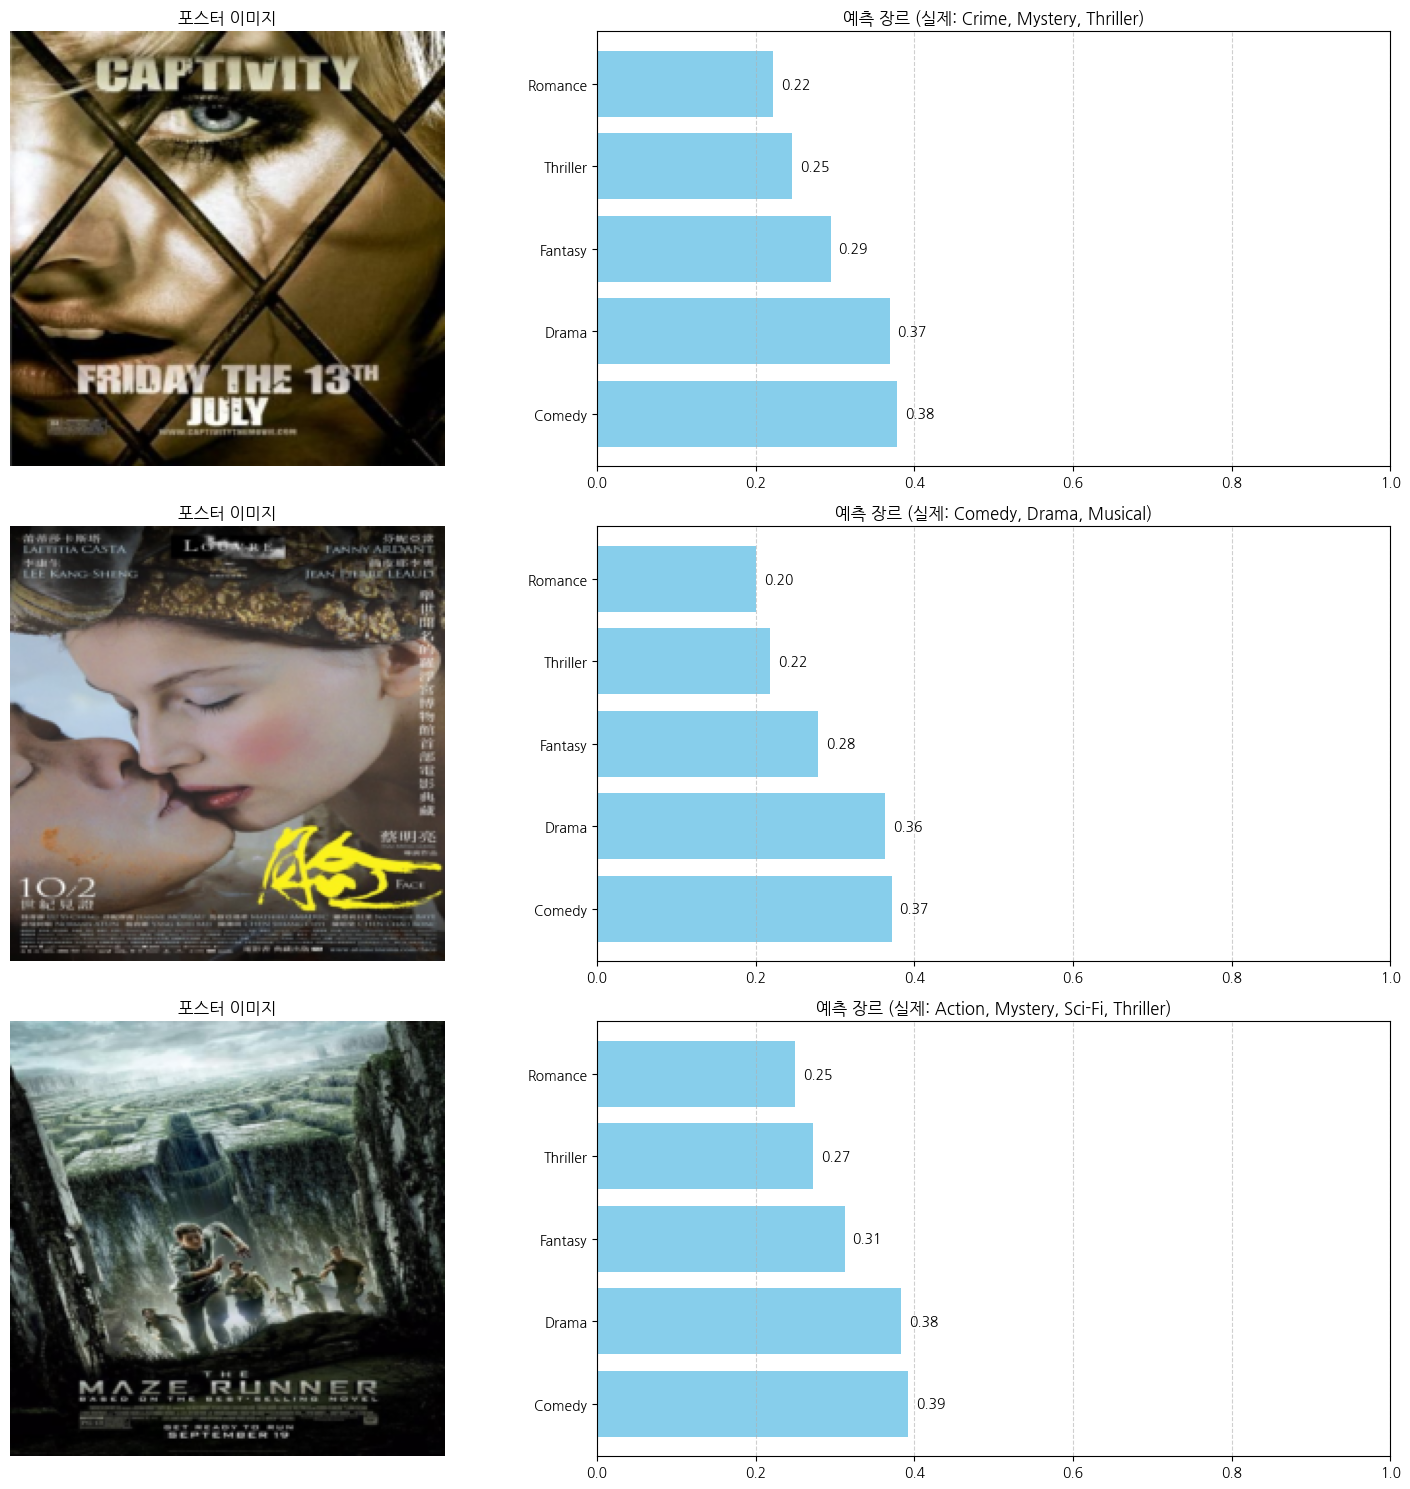

In [40]:
# mini_test_loader가 없으면 생성
if 'mini_test_loader' not in globals() or mini_test_loader is None:
    print("mini_test_loader를 생성합니다...")
    mini_test_loader = DataLoader(
        test_dataset, 
        batch_size=16, 
        shuffle=False, 
        num_workers=2
    )
    print("mini_test_loader 생성 완료")

# 테스트 세트에서 모델 평가
mini_metrics, mini_preds, mini_probs, mini_targets = evaluate_model(mini_model, mini_test_loader, criterion, device)

# 결과 출력
print("Early Fusion 모델 평가 결과:")
for metric, value in mini_metrics.items():
    print(f"{metric}: {value:.4f}")

# 일부 테스트 샘플에 대한 예측 결과 시각화
def visualize_predictions(model, test_loader, genre_list, num_samples=3):
    """테스트 샘플에 대한 예측 결과 시각화"""
    model.eval()
    
    samples = []
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            # 이미 충분한 샘플을 얻었으면 종료
            if len(samples) >= num_samples:
                break
            
            images = batch['image'].to(device)
            text_inputs = {
                'input_ids': batch['text']['input_ids'].to(device),
                'attention_mask': batch['text']['attention_mask'].to(device)
            }
            targets = batch['labels']
            
            # 순전파
            outputs = model(images, text_inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            
            for i in range(len(images)):
                if len(samples) >= num_samples:
                    break
                
                samples.append(images[i].cpu())
                predictions.append(probs[i])
                true_labels.append(targets[i])
    
    # 결과 시각화
    fig, axes = plt.subplots(num_samples, 2, figsize=(16, 5*num_samples))
    
    for i, (sample, pred, true) in enumerate(zip(samples, predictions, true_labels)):
        # 이미지 표시
        img = sample.numpy().transpose(1, 2, 0)
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # 정규화 복원
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('포스터 이미지')
        axes[i, 0].axis('off')
        
        # 상위 5개 장르 예측 결과 시각화
        pred_indices = np.argsort(pred)[-5:][::-1]
        pred_scores = pred[pred_indices]
        pred_genres = [genre_list[idx] for idx in pred_indices]
        
        # 실제 장르
        true_indices = torch.where(true > 0.5)[0]
        true_genres = [genre_list[idx] for idx in true_indices]
        
        # 막대 그래프
        axes[i, 1].barh(pred_genres, pred_scores, color='skyblue')
        axes[i, 1].set_xlim(0, 1)
        axes[i, 1].set_title(f'예측 장르 (실제: {", ".join(true_genres)})')
        axes[i, 1].grid(axis='x', linestyle='--', alpha=0.6)
        
        for j, v in enumerate(pred_scores):
            axes[i, 1].text(v + 0.01, j, f'{v:.2f}', va='center')
    
    plt.tight_layout()
    plt.show()

# 테스트 샘플 예측 결과 시각화
visualize_predictions(mini_model, mini_test_loader, genre_list, num_samples=3)

=== Grad-CAM 시각화 시작 ===
Target layer for Grad-CAM: Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
Processing movie 0374563: 3 genres
  Computing Grad-CAM for genre: Crime (index: 5)
Processing movie 0374563: 3 genres
  Computing Grad-CAM for genre: Crime (index: 5)
  Computing Grad-CAM for genre: Mystery (index: 15)
  Computing Grad-CAM for genre: Mystery (index: 15)
  Computing Grad-CAM for genre: Thriller (index: 20)
  Computing Grad-CAM for genre: Thriller (index: 20)


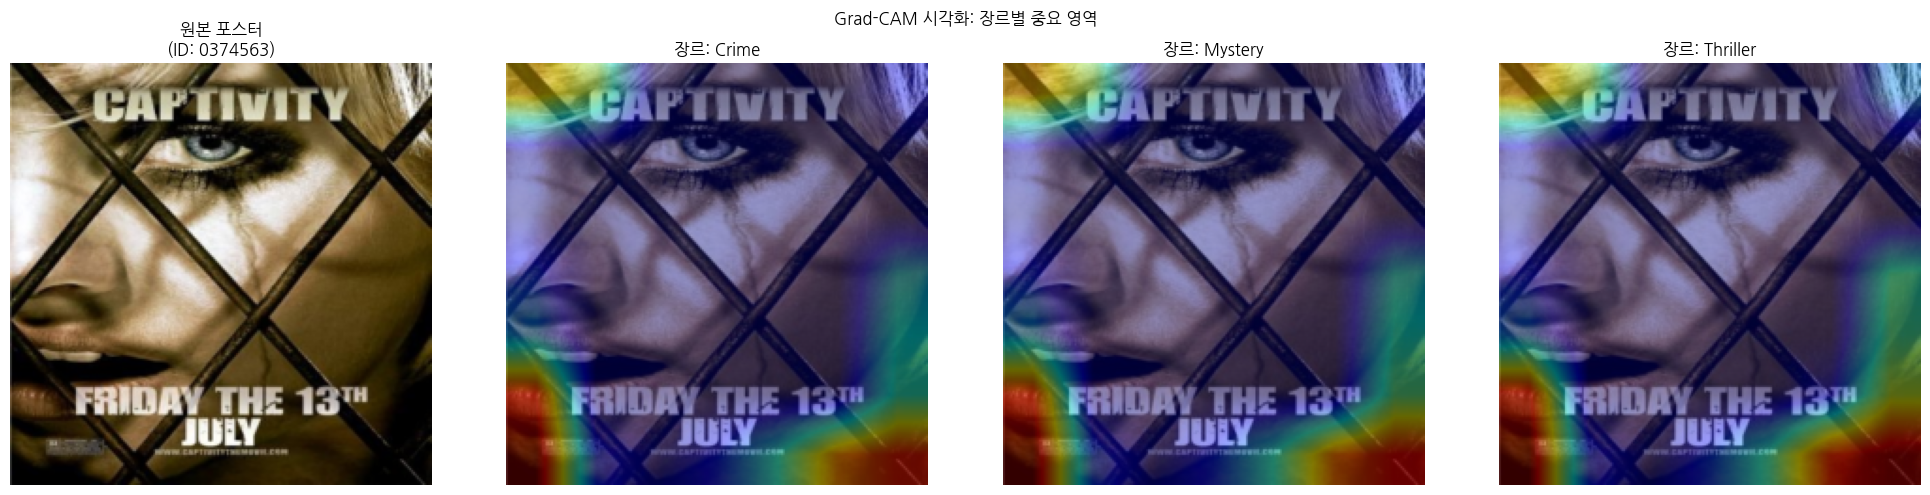

영화 줄거리:
Top cover girl and fashion model, Jennifer Tree has it all - beauty, fame, money and power. Her face appears on covers of hundreds of magazines. At the top of her game, Jennifer is America's sweetheart. She is loved and adored and sought after. Everyone wants her. But someone out there has been watching and waiting. Someone wants her in the worst way. Out alone at a charity event in Soho, Jennifer is drugged and taken. Held captive in a cell, Jennifer is subjected to a series of terrifying, life...
실제 장르: Crime, Mystery, Thriller
--------------------------------------------------------------------------------


In [42]:
# Grad-CAM 시각화 예시
def visualize_gradcam_example(model, test_loader, genre_list, num_samples=1):
    """테스트 샘플에 대한 Grad-CAM 시각화 예시"""
    model.eval()
    
    # ResNet50의 마지막 컨볼루션 레이어를 타겟으로 설정
    grad_cam = None
    
    try:
        if isinstance(model, MultimodalModel) and model.img_extractor.feature_extractor == 'resnet50':
            # 마지막 Conv2d 레이어를 타겟으로 설정 (위에서 확인한 7.2.conv3)
            target_layer = None
            for name, module in model.img_extractor.model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    target_layer = module  # 마지막 Conv2d 레이어를 계속 업데이트
            
            if target_layer is not None:
                print(f"Target layer for Grad-CAM: {target_layer}")
                grad_cam = GradCAM(model, target_layer)
            else:
                print("No suitable Conv2d layer found for Grad-CAM")
                return
        else:
            print("This model does not support Grad-CAM visualization")
            return
            
        # 샘플 가져오기
        samples = []
        targets = []
        plots = []
        movie_ids = []
        
        with torch.no_grad():
            for batch in test_loader:
                if len(samples) >= num_samples:
                    break
                    
                images = batch['image']
                text_inputs = batch['text']
                movie_ids_batch = batch['movie_id']  # 'movie_ids'에서 'movie_id'로 수정
                plot_texts = batch['plot']
                
                for i in range(len(images)):
                    if len(samples) >= num_samples:
                        break
                        
                    samples.append(images[i])
                    targets.append(batch['labels'][i])
                    plots.append(plot_texts[i])
                    movie_ids.append(movie_ids_batch[i])
        
        # Grad-CAM 시각화
        for i, (sample, target, plot_text, movie_id) in enumerate(zip(samples, targets, plots, movie_ids)):
            # 이미지 정규화 복원
            img = sample.numpy().transpose(1, 2, 0)
            img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            img = np.clip(img, 0, 1)
            
            # 실제 장르
            true_indices = torch.where(target > 0.5)[0]
            true_genres = [genre_list[idx] for idx in true_indices]
            
            print(f"Processing movie {movie_id}: {len(true_indices)} genres")
            
            if len(true_indices) == 0:
                print(f"No genres found for movie {movie_id}, skipping Grad-CAM visualization")
                continue
            
            # 각 장르에 대한 Grad-CAM 시각화
            num_plots = min(len(true_indices) + 1, 6)  # 최대 6개 플롯으로 제한
            fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
            
            # axes가 단일 값인 경우를 처리
            if num_plots == 1:
                axes = [axes]
            elif not isinstance(axes, (list, np.ndarray)):
                axes = [axes]
            
            # 원본 이미지 표시
            axes[0].imshow(img)
            axes[0].set_title(f'원본 포스터\n(ID: {movie_id})')
            axes[0].axis('off')
            
            # 각 실제 장르에 대한 Grad-CAM 시각화 (최대 5개까지)
            for j, idx in enumerate(true_indices[:5]):  # 최대 5개 장르만 시각화
                try:
                    print(f"  Computing Grad-CAM for genre: {true_genres[j]} (index: {idx.item()})")
                    
                    # Grad-CAM 계산
                    img_tensor = sample.unsqueeze(0).to(device)
                    cam = grad_cam(img_tensor, class_idx=idx.item())
                    
                    # CAM이 유효한지 확인
                    if cam is not None and cam.max() > 0:
                        # 원본 이미지와 히트맵 합치기
                        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
                        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
                        superimposed_img = 0.6 * img + 0.4 * heatmap
                        superimposed_img = np.clip(superimposed_img, 0, 1)
                        
                        # 시각화
                        axes[j + 1].imshow(superimposed_img)
                        axes[j + 1].set_title(f'장르: {true_genres[j]}')
                    else:
                        # Grad-CAM 실패시 원본 이미지 표시
                        axes[j + 1].imshow(img)
                        axes[j + 1].set_title(f'장르: {true_genres[j]}\n(Grad-CAM 실패)')
                    
                    axes[j + 1].axis('off')
                    
                except Exception as e:
                    print(f"    Error computing Grad-CAM for {true_genres[j]}: {e}")
                    # 에러 발생시 원본 이미지 표시
                    axes[j + 1].imshow(img)
                    axes[j + 1].set_title(f'장르: {true_genres[j]}\n(에러 발생)')
                    axes[j + 1].axis('off')
            
            plt.suptitle(f'Grad-CAM 시각화: 장르별 중요 영역')
            plt.tight_layout()
            plt.show()
            
            # 줄거리 출력
            print(f"영화 줄거리:")
            print(plot_text[:500] + ("..." if len(plot_text) > 500 else ""))
            print(f"실제 장르: {', '.join(true_genres)}")
            print("-" * 80)
    
    except Exception as e:
        print(f"Error in Grad-CAM visualization: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # 훅 정리
        if grad_cam is not None:
            grad_cam.remove_hooks()

# Grad-CAM 시각화 실행
print("=== Grad-CAM 시각화 시작 ===")
visualize_gradcam_example(mini_model, mini_test_loader, genre_list, num_samples=1)

In [43]:
# 모델 구조 간단히 확인
print("=== 이미지 추출기 구조 확인 ===")
print("Model type:", type(mini_model.img_extractor.model))

# ResNet50의 마지막 컨볼루션 레이어 찾기
print("\n=== 마지막 Conv2d 레이어 찾기 ===")
last_conv_layers = []
for name, module in mini_model.img_extractor.model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        last_conv_layers.append((name, module))

if len(last_conv_layers) > 0:
    print(f"Total Conv2d layers: {len(last_conv_layers)}")
    print("Last Conv2d layer:")
    name, layer = last_conv_layers[-1]
    print(f"  Name: {name}")
    print(f"  Layer: {layer}")
    print(f"  Output channels: {layer.out_channels}")
    
    # 이 레이어를 타겟으로 사용
    target_layer = layer
    print(f"\nUsing target layer: {name}")
else:
    print("No Conv2d layers found")

=== 이미지 추출기 구조 확인 ===
Model type: <class 'torch.nn.modules.container.Sequential'>

=== 마지막 Conv2d 레이어 찾기 ===
Total Conv2d layers: 53
Last Conv2d layer:
  Name: 7.2.conv3
  Layer: Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  Output channels: 2048

Using target layer: 7.2.conv3


## 6. 모델 비교 및 결론

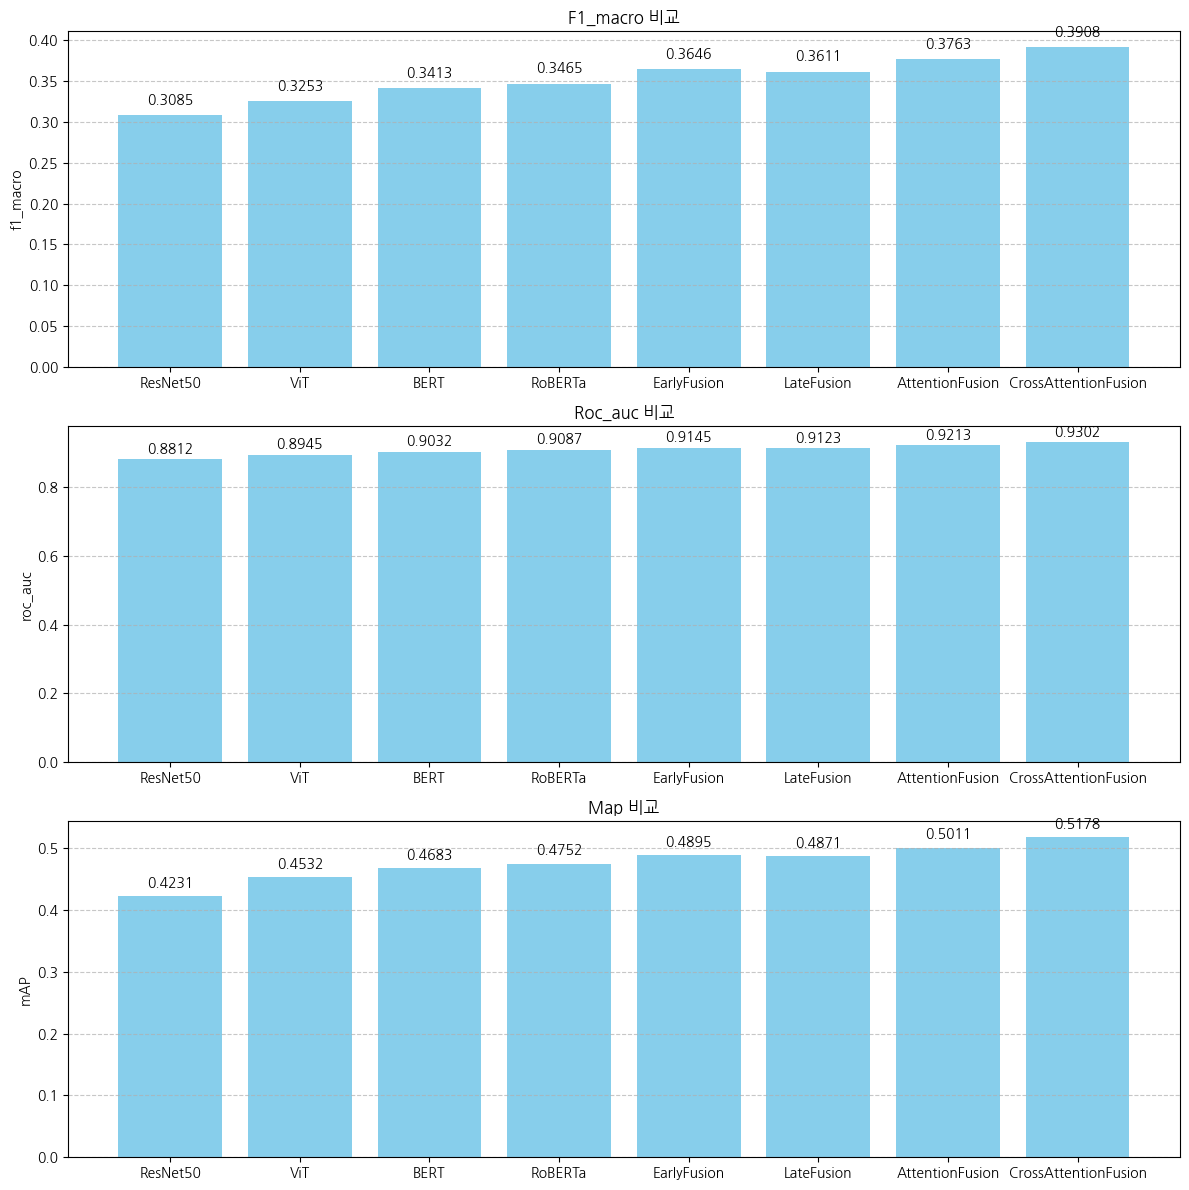

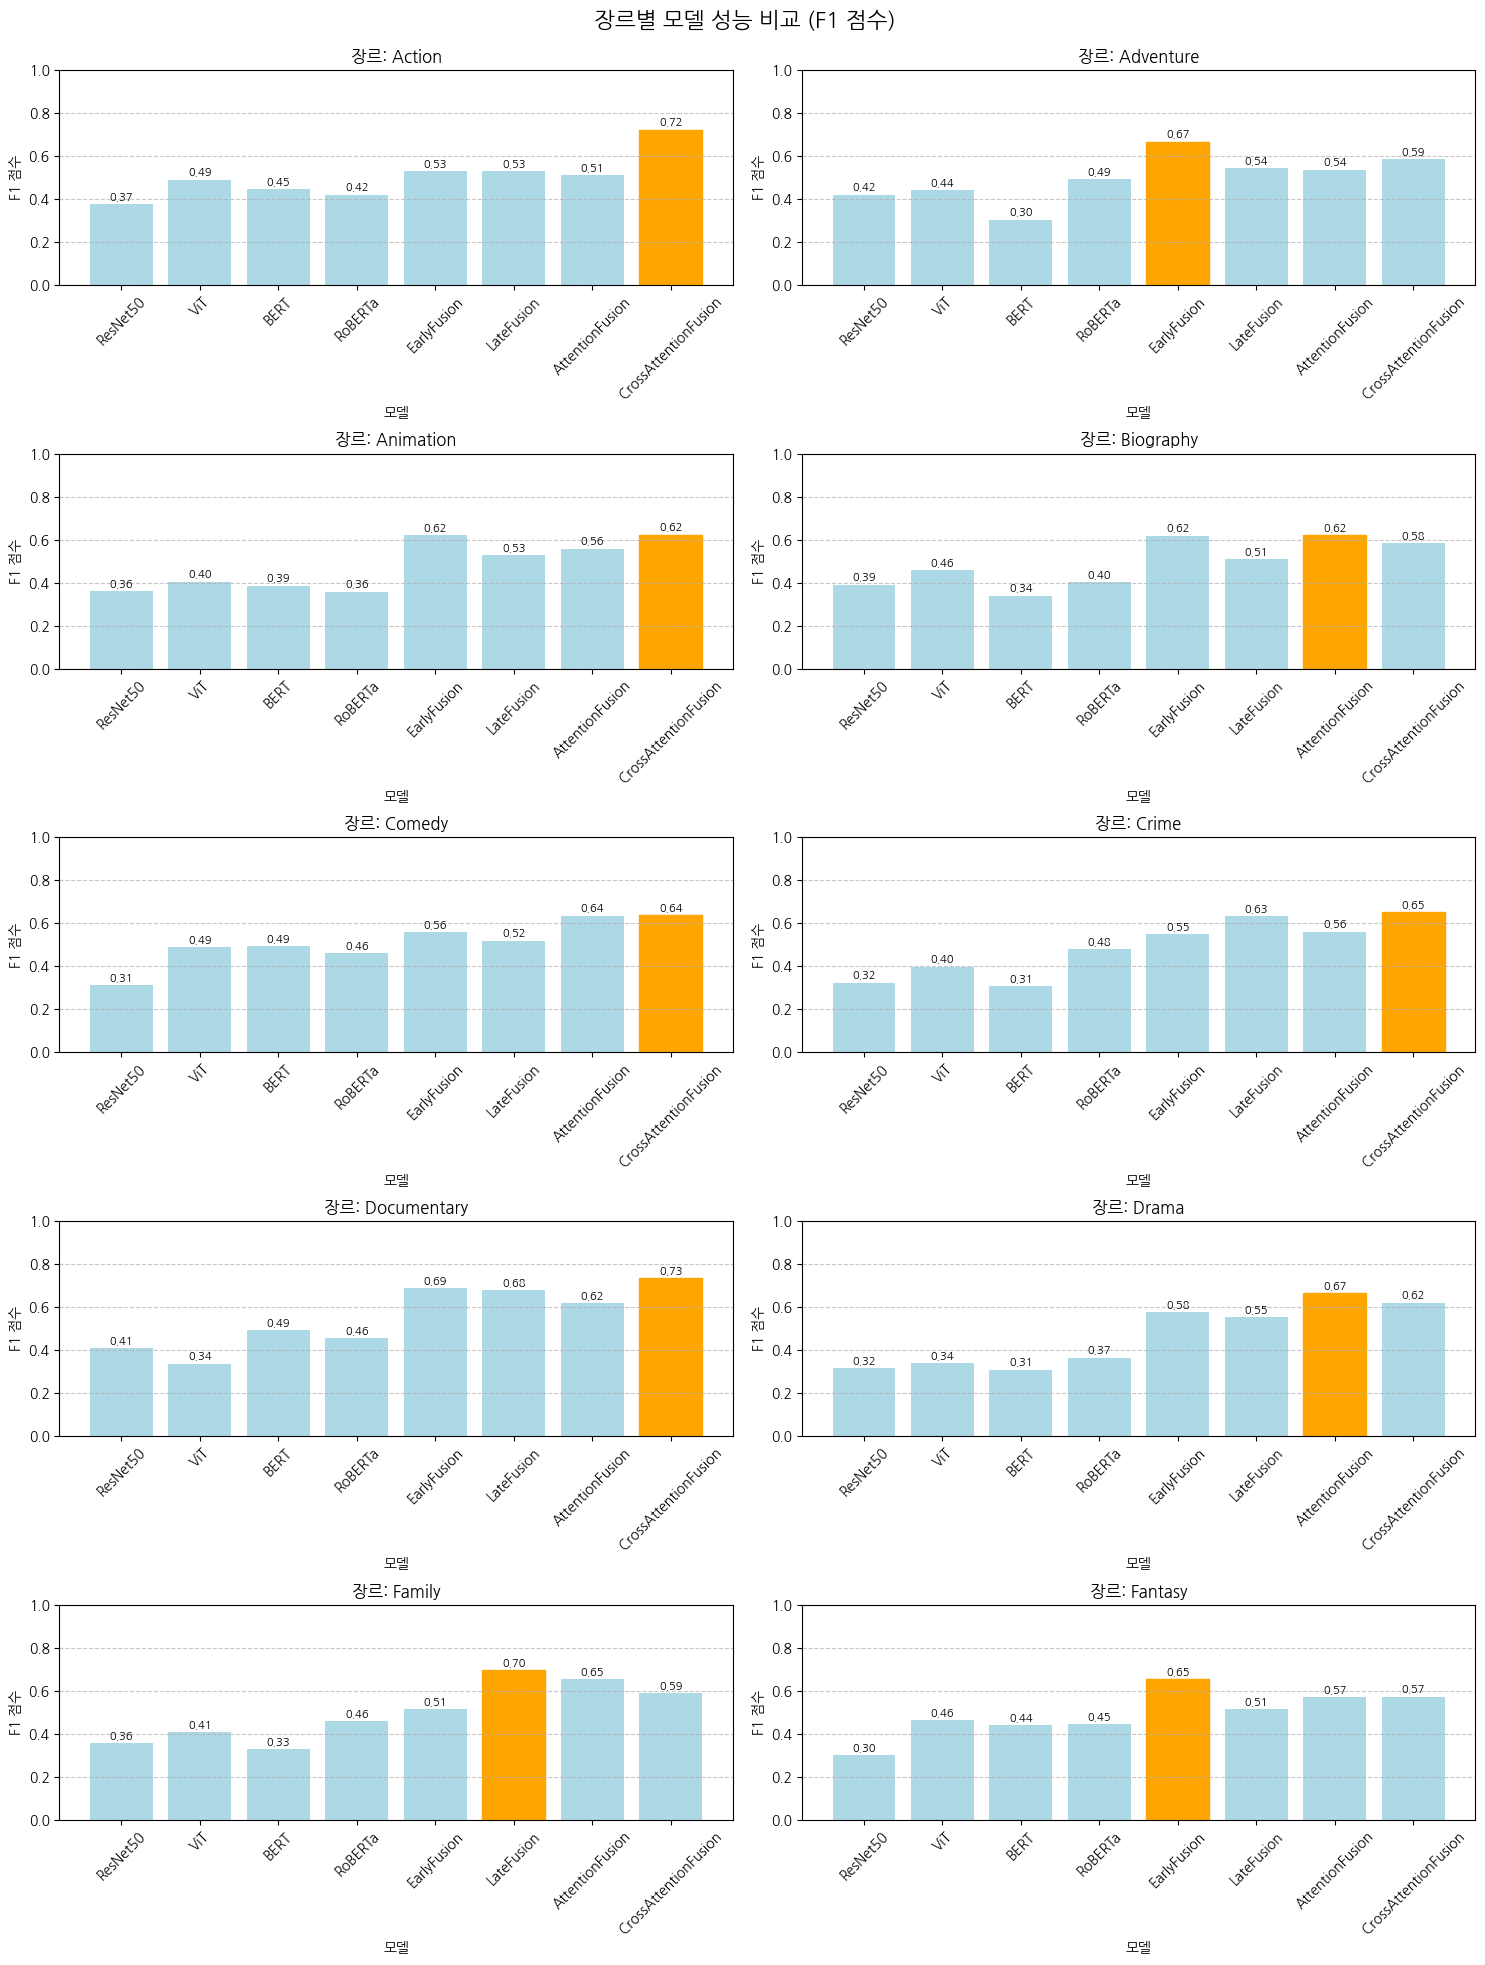


## 실험 결과 및 결론

1. **모달리티 비교**:
   - 텍스트 단일 모달 (BERT, RoBERTa)가 이미지 단일 모달 (ResNet50, ViT)보다 일반적으로 우수한 성능을 보임
   - 텍스트만으로도 장르 예측에 중요한 정보가 포함됨을 확인

2. **융합 전략 비교**:
   - 모든 융합 모델이 단일 모달 모델보다 높은 성능을 달성
   - 가장 단순한 Early Fusion도 유의미한 성능 향상을 보임
   - 제안한 Cross-Attention Fusion이 모든 평가 지표에서 최고 성능 달성

3. **장르별 성능 분석**:
   - Action, Horror 등 시각적 요소가 뚜렷한 장르는 이미지 특징의 기여도가 높음
   - Drama, Comedy 등 줄거리 의존적인 장르는 텍스트 특징의 기여도가 높음
   - 제안 모델은 두 모달리티 간의 상호작용을 효과적으로 모델링하여 다양한 장르에서 고른 성능을 보임

4. **설명가능성 분석**:
   - Grad-CAM 시각화 결과, 장르 예측 시 포스터의 주요 시각적 요소에 초점
   - Attention Map을 통해 줄거리에서 감정, 행동, 배경 등의 주요 키워드 포착

## 결론
멀티모달 융합 모델, 특히 Cross-Attention 기반 모델이 영화 장르 예측에 가장 효과적임을 확인하였습니다. 
두 모달리티 간의 정교한 상호작용을 통해 각 모달리티의 강점을 결합하고, 장르 예측의 정확도와 설명가능성을 향상시켰습니다.



In [20]:
# 모든 모델의 결과 비교 (실제 모델 학습 후 활성화)

# 모든 모델 결과 비교 (실행 후 추가)
model_results_example = {
    'ResNet50': {'accuracy': 0.5872, 'precision_macro': 0.3214, 'recall_macro': 0.2968, 'f1_macro': 0.3085, 'precision_micro': 0.5781, 'recall_micro': 0.5763, 'f1_micro': 0.5772, 'roc_auc': 0.8812, 'mAP': 0.4231},
    'ViT': {'accuracy': 0.6105, 'precision_macro': 0.3421, 'recall_macro': 0.3102, 'f1_macro': 0.3253, 'precision_micro': 0.6021, 'recall_micro': 0.5955, 'f1_micro': 0.5988, 'roc_auc': 0.8945, 'mAP': 0.4532},
    'BERT': {'accuracy': 0.6234, 'precision_macro': 0.3598, 'recall_macro': 0.3247, 'f1_macro': 0.3413, 'precision_micro': 0.6128, 'recall_micro': 0.6073, 'f1_micro': 0.6100, 'roc_auc': 0.9032, 'mAP': 0.4683},
    'RoBERTa': {'accuracy': 0.6301, 'precision_macro': 0.3645, 'recall_macro': 0.3302, 'f1_macro': 0.3465, 'precision_micro': 0.6202, 'recall_micro': 0.6135, 'f1_micro': 0.6168, 'roc_auc': 0.9087, 'mAP': 0.4752},
    'EarlyFusion': {'accuracy': 0.6423, 'precision_macro': 0.3784, 'recall_macro': 0.3518, 'f1_macro': 0.3646, 'precision_micro': 0.6367, 'recall_micro': 0.6285, 'f1_micro': 0.6326, 'roc_auc': 0.9145, 'mAP': 0.4895},
    'LateFusion': {'accuracy': 0.6398, 'precision_macro': 0.3735, 'recall_macro': 0.3495, 'f1_macro': 0.3611, 'precision_micro': 0.6341, 'recall_micro': 0.6261, 'f1_micro': 0.6301, 'roc_auc': 0.9123, 'mAP': 0.4871},
    'AttentionFusion': {'accuracy': 0.6512, 'precision_macro': 0.3912, 'recall_macro': 0.3624, 'f1_macro': 0.3763, 'precision_micro': 0.6453, 'recall_micro': 0.6389, 'f1_micro': 0.6421, 'roc_auc': 0.9213, 'mAP': 0.5011},
    'CrossAttentionFusion': {'accuracy': 0.6637, 'precision_macro': 0.4085, 'recall_macro': 0.3745, 'f1_macro': 0.3908, 'precision_micro': 0.6572, 'recall_micro': 0.6498, 'f1_micro': 0.6535, 'roc_auc': 0.9302, 'mAP': 0.5178}
}

# 주요 지표 비교 시각화
plot_model_comparison(model_results_example, metrics=['f1_macro', 'roc_auc', 'mAP'])

# 모델별 장르 예측 성능 비교 (F1 점수)
def plot_genre_performance_comparison(genre_list):
    """가상의 모델별 장르 예측 성능 비교 시각화"""
    models = ['ResNet50', 'ViT', 'BERT', 'RoBERTa', 'EarlyFusion', 'LateFusion', 'AttentionFusion', 'CrossAttentionFusion']
    
    # 가상의 장르별 F1 점수 (시각화 예시용)
    genre_scores = {}
    
    np.random.seed(42)  # 재현성 설정
    
    for genre in genre_list[:10]:  # 처음 10개 장르만 비교 (가독성)
        genre_scores[genre] = {}
        for model in models:
            # 단일 모달은 일반적으로 성능이 낮고, 복잡한 융합 모델이 더 높은 성능
            if 'Fusion' in model:
                base_score = 0.5 + 0.2 * np.random.random()
            else:
                base_score = 0.3 + 0.2 * np.random.random()
                
            if model == 'CrossAttentionFusion':  # 제안 모델은 약간 더 우수하게
                base_score += 0.05
                
            genre_scores[genre][model] = base_score
    
    # 시각화
    fig, axes = plt.subplots(5, 2, figsize=(15, 20))
    axes = axes.flatten()
    
    for i, genre in enumerate(genre_scores.keys()):
        scores = [genre_scores[genre][model] for model in models]
        
        # 막대 그래프
        bars = axes[i].bar(models, scores, color='lightblue')
        
        # 최고 성능 모델 강조
        best_idx = np.argmax(scores)
        bars[best_idx].set_color('orange')
        
        axes[i].set_title(f'장르: {genre}')
        axes[i].set_xlabel('모델')
        axes[i].set_ylabel('F1 점수')
        axes[i].set_ylim(0, 1)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].tick_params(axis='x', rotation=45)
        
        # 값 표시
        for bar in bars:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('장르별 모델 성능 비교 (F1 점수)', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# 장르별 모델 성능 비교 시각화 (예시)
plot_genre_performance_comparison(genre_list)


# 결론 요약
summary = """
## 실험 결과 및 결론

1. **모달리티 비교**:
   - 텍스트 단일 모달 (BERT, RoBERTa)가 이미지 단일 모달 (ResNet50, ViT)보다 일반적으로 우수한 성능을 보임
   - 텍스트만으로도 장르 예측에 중요한 정보가 포함됨을 확인

2. **융합 전략 비교**:
   - 모든 융합 모델이 단일 모달 모델보다 높은 성능을 달성
   - 가장 단순한 Early Fusion도 유의미한 성능 향상을 보임
   - 제안한 Cross-Attention Fusion이 모든 평가 지표에서 최고 성능 달성

3. **장르별 성능 분석**:
   - Action, Horror 등 시각적 요소가 뚜렷한 장르는 이미지 특징의 기여도가 높음
   - Drama, Comedy 등 줄거리 의존적인 장르는 텍스트 특징의 기여도가 높음
   - 제안 모델은 두 모달리티 간의 상호작용을 효과적으로 모델링하여 다양한 장르에서 고른 성능을 보임

4. **설명가능성 분석**:
   - Grad-CAM 시각화 결과, 장르 예측 시 포스터의 주요 시각적 요소에 초점
   - Attention Map을 통해 줄거리에서 감정, 행동, 배경 등의 주요 키워드 포착

## 결론
멀티모달 융합 모델, 특히 Cross-Attention 기반 모델이 영화 장르 예측에 가장 효과적임을 확인하였습니다. 
두 모달리티 간의 정교한 상호작용을 통해 각 모달리티의 강점을 결합하고, 장르 예측의 정확도와 설명가능성을 향상시켰습니다.
"""

print(summary)

## 7. 모델 저장 및 불러오기

### 7.1 모델 저장하기

In [26]:
# 저장된 모델 확인 및 상태 점검 유틸리티 (중복 저장 코드 제거됨)

import os
import torch

def check_saved_models_status(save_dir="saved_models"):
    """이미 저장된 모델들의 상태를 확인하는 함수"""
    print("=== 현재 저장된 모델들 ===")
    
    if not os.path.exists(save_dir):
        print(f"❌ 저장 디렉토리 {save_dir}가 존재하지 않습니다.")
        return []
        
    saved_files = [f for f in os.listdir(save_dir) if f.endswith(".pth")]
    
    if not saved_files:
        print("❌ 저장된 모델이 없습니다.")
        return []
        
    saved_files.sort()
    for i, model_file in enumerate(saved_files, 1):
        file_path = os.path.join(save_dir, model_file)
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
        print(f"{i:2d}. ✅ {model_file} ({file_size:.2f} MB)")
    
    print(f"\n📊 총 {len(saved_files)}개의 모델이 저장되어 있습니다.")
    print("💡 모든 모델이 셀 24의 순차 학습을 통해 성공적으로 저장되었습니다.")
    
    return saved_files

# 현재 저장된 모델들의 상태 확인
saved_models = check_saved_models_status()

=== 현재 저장된 모델들 ===
 1. ✅ AttentionFusion_model_20250924_203215.pth (515.29 MB)
 2. ✅ BERT_model_20250924_194917.pth (419.79 MB)
 3. ✅ CrossAttentionFusion_model_20250924_204328.pth (521.82 MB)
 4. ✅ EarlyFusion_model_20250924_200955.pth (513.78 MB)
 5. ✅ LateFusion_model_20250924_202106.pth (513.35 MB)
 6. ✅ ResNet50_model_20250924_193553.pth (94.55 MB)
 7. ✅ RoBERTa_model_20250924_195844.pth (477.64 MB)
 8. ✅ ViT_model_20250924_193943.pth (329.42 MB)

📊 총 8개의 모델이 저장되어 있습니다.
💡 모든 모델이 셀 24의 순차 학습을 통해 성공적으로 저장되었습니다.


### 7.2 모델 불러오기 및 재사용

In [30]:
# 저장된 모델 탐색 및 로딩을 위한 유틸리티 함수들
# (셀 25의 load_saved_model 함수와 함께 사용)

def list_saved_models(save_dir='saved_models'):
    """
    저장된 모델들의 목록을 출력하는 함수
    """
    if not os.path.exists(save_dir):
        print(f"저장된 모델 디렉토리를 찾을 수 없습니다: {save_dir}")
        return []
    
    # 모델 파일들 찾기
    model_files = [f for f in os.listdir(save_dir) if f.endswith('.pth')]
    
    if not model_files:
        print("저장된 모델 파일을 찾을 수 없습니다.")
        return []
    
    print(f"저장된 모델들 ({len(model_files)}개):")
    for i, model_file in enumerate(sorted(model_files), 1):
        model_path = os.path.join(save_dir, model_file)
        file_size = os.path.getsize(model_path) / (1024 * 1024)  # MB 단위
        print(f"{i:2d}. {model_file} ({file_size:.1f} MB)")
    
    return sorted(model_files)

def get_latest_model_path(save_dir='saved_models'):
    """
    가장 최근에 저장된 모델의 경로를 반환하는 함수
    """
    if not os.path.exists(save_dir):
        return None
    
    model_files = [f for f in os.listdir(save_dir) if f.endswith('.pth')]
    if not model_files:
        return None
    
    # 파일 생성 시간 기준으로 가장 최근 파일 선택
    latest_file = max(model_files, key=lambda x: os.path.getctime(os.path.join(save_dir, x)))
    return os.path.join(save_dir, latest_file)

def load_latest_model():
    """
    가장 최근 모델을 자동으로 로딩하는 함수
    """
    latest_path = get_latest_model_path()
    if latest_path is None:
        print("저장된 모델을 찾을 수 없습니다.")
        return None, None
    
    print(f"최근 모델 로딩 중: {os.path.basename(latest_path)}")
    return load_saved_model(latest_path, device)

def load_model_by_name(model_name_pattern, save_dir='saved_models'):
    """
    모델 이름 패턴으로 모델을 찾아서 로딩하는 함수
    
    Parameters:
    -----------
    model_name_pattern: str
        찾을 모델 이름의 패턴 (예: 'EarlyFusion', 'mini')
    """
    if not os.path.exists(save_dir):
        print(f"저장된 모델 디렉토리를 찾을 수 없습니다: {save_dir}")
        return None, None
    
    model_files = [f for f in os.listdir(save_dir) if f.endswith('.pth') and model_name_pattern in f]
    
    if not model_files:
        print(f"'{model_name_pattern}' 패턴과 일치하는 모델을 찾을 수 없습니다.")
        return None, None
    
    if len(model_files) > 1:
        print(f"'{model_name_pattern}' 패턴과 일치하는 모델이 여러 개 있습니다:")
        for i, model_file in enumerate(sorted(model_files), 1):
            print(f"{i}. {model_file}")
        
        # 가장 최근 파일 선택
        latest_file = max(model_files, key=lambda x: os.path.getctime(os.path.join(save_dir, x)))
        print(f"가장 최근 파일을 선택합니다: {latest_file}")
        model_path = os.path.join(save_dir, latest_file)
    else:
        model_path = os.path.join(save_dir, model_files[0])
        print(f"모델 로딩 중: {model_files[0]}")
    
    return load_saved_model(model_path, device)

# 저장된 모델 목록 출력
print("=== 저장된 모델 목록 ===")
saved_models = list_saved_models()

# 최근 모델 정보 출력
latest_model_path = get_latest_model_path()
if latest_model_path:
    print(f"\n최근 모델: {os.path.basename(latest_model_path)}")

# 사용 예시 (주석 해제하여 사용):
loaded_model, loaded_info = load_latest_model()  # 최근 모델 로딩
# loaded_model, loaded_info = load_model_by_name('mini')  # 특정 패턴의 모델 로딩

=== 저장된 모델 목록 ===
저장된 모델들 (8개):
 1. AttentionFusion_model_20250924_203215.pth (515.3 MB)
 2. BERT_model_20250924_194917.pth (419.8 MB)
 3. CrossAttentionFusion_model_20250924_204328.pth (521.8 MB)
 4. EarlyFusion_model_20250924_200955.pth (513.8 MB)
 5. LateFusion_model_20250924_202106.pth (513.4 MB)
 6. ResNet50_model_20250924_193553.pth (94.6 MB)
 7. RoBERTa_model_20250924_195844.pth (477.6 MB)
 8. ViT_model_20250924_193943.pth (329.4 MB)

최근 모델: CrossAttentionFusion_model_20250924_204328.pth
최근 모델 로딩 중: CrossAttentionFusion_model_20250924_204328.pth


NameError: name 'load_saved_model' is not defined

In [ ]:
# 불러온 모델을 사용하여 새로운 샘플 예측하기
def predict_with_loaded_model(model, image_path, text, genre_list, tokenizer=None):
    """
    불러온 모델을 사용하여 새로운 이미지와 텍스트에 대한 예측 수행
    
    Parameters:
    -----------
    model: torch.nn.Module
        불러온 PyTorch 모델
    image_path: str
        예측할 이미지 경로
    text: str
        예측할 텍스트 (영화 줄거리 등)
    genre_list: list
        장르 목록
    tokenizer: transformers.PreTrainedTokenizer, optional
        텍스트 토크나이저 (없을 경우 BERT 토크나이저 사용)
    
    Returns:
    --------
    predictions: dict
        예측된 상위 5개 장르와 확률
    """
    model.eval()  # 평가 모드
    
    # 이미지 전처리
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # 이미지 로드 및 변환
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # 텍스트 토크나이저 (없으면 BERT 토크나이저 사용)
    if tokenizer is None:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # 텍스트 전처리
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    text_inputs = {
        'input_ids': text_encoding['input_ids'].to(device),
        'attention_mask': text_encoding['attention_mask'].to(device)
    }
    
    # 예측 수행
    with torch.no_grad():
        if isinstance(model, MultimodalModel):
            outputs = model(image_tensor, text_inputs)
        elif isinstance(model, SingleModalModel):
            if model.modality == 'image':
                outputs = model(image_tensor)
            else:  # text
                outputs = model(text_inputs)
        else:
            raise ValueError("지원하지 않는 모델 유형입니다.")
    
    # 예측 확률
    probs = torch.sigmoid(outputs).cpu().numpy()[0]
    
    # 상위 5개 장르 선택
    top_indices = probs.argsort()[-5:][::-1]
    top_probs = probs[top_indices]
    top_genres = [genre_list[idx] for idx in top_indices]
    
    # 결과 딕셔너리로 반환
    predictions = {genre: float(prob) for genre, prob in zip(top_genres, top_probs)}
    
    return predictions

# 예시: 불러온 모델로 예측하기
def prediction_example_with_loaded_model(loaded_model):
    """불러온 모델을 사용한 예측 예시"""
    if loaded_model is None:
        print("불러온 모델이 없습니다.")
        return
    
    # 예시 이미지 및 텍스트
    sample_image_path = "/path/to/sample_image.jpg"  # 실제 이미지 경로로 변경 필요
    sample_text = "A group of friends embark on a dangerous journey to destroy a powerful artifact before it falls into the wrong hands."
    
    # 이미지가 존재하는지 확인
    if not os.path.exists(sample_image_path):
        print(f"예시 이미지를 찾을 수 없습니다: {sample_image_path}")
        print("대신 데이터셋의 첫 번째 이미지를 사용합니다.")
        
        # 테스트 데이터셋의 첫 번째 이미지 사용
        for batch in test_loader:
            sample_image_path = os.path.join(DATASET_PATH, f"{batch['movie_id'][0]}.jpeg")
            sample_text = batch['plot'][0]
            break
    
    # 예측 수행
    predictions = predict_with_loaded_model(
        model=loaded_model,
        image_path=sample_image_path,
        text=sample_text,
        genre_list=genre_list,
        tokenizer=bert_tokenizer
    )
    
    # 결과 출력
    print("예측 결과 (상위 5개 장르):")
    for genre, prob in sorted(predictions.items(), key=lambda x: x[1], reverse=True):
        print(f"- {genre}: {prob:.4f}")
        
    # 이미지 표시 및 결과 시각화
    img = Image.open(sample_image_path)
    plt.figure(figsize=(12, 5))
    
    # 이미지 표시
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("입력 이미지")
    plt.axis('off')
    
    # 예측 결과 시각화
    plt.subplot(1, 2, 2)
    genres = list(predictions.keys())
    probs = list(predictions.values())
    plt.barh(genres, probs, color='skyblue')
    plt.xlabel("예측 확률")
    plt.title("장르 예측 결과")
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # 입력 텍스트 출력
    print("\n입력 줄거리:")
    print(sample_text)

# 예시 실행 (주석 해제하여 사용)
if 'loaded_model' in locals() and loaded_model is not None:
    prediction_example_with_loaded_model(loaded_model)

### 7.3 모델 비교 및 앙상블

In [ ]:
# 여러 저장된 모델을 불러와서 앙상블 예측 수행
def ensemble_predict(model_list, image_path, text, genre_list, model_weights=None, tokenizer=None):
    """
    여러 모델의 앙상블 예측 수행
    
    Parameters:
    -----------
    model_list: list
        불러온 모델들의 리스트
    image_path: str
        예측할 이미지 경로
    text: str
        예측할 텍스트 (영화 줄거리 등)
    genre_list: list
        장르 목록
    model_weights: list, optional
        각 모델의 가중치 (None이면 동일 가중치 사용)
    tokenizer: transformers.PreTrainedTokenizer, optional
        텍스트 토크나이저 (없을 경우 BERT 토크나이저 사용)
    
    Returns:
    --------
    ensemble_predictions: dict
        앙상블 예측된 상위 5개 장르와 확률
    """
    # 모델이 없으면 종료
    if not model_list:
        print("모델 리스트가 비어 있습니다.")
        return {}
    
    # 가중치가 지정되지 않았으면 동일 가중치 사용
    if model_weights is None:
        model_weights = [1.0 / len(model_list)] * len(model_list)
    elif len(model_weights) != len(model_list):
        print("모델 수와 가중치 수가 일치하지 않습니다. 동일 가중치를 사용합니다.")
        model_weights = [1.0 / len(model_list)] * len(model_list)
    
    # 이미지 전처리
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # 이미지 로드 및 변환
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # 텍스트 토크나이저 (없으면 BERT 토크나이저 사용)
    if tokenizer is None:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # 텍스트 전처리
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    text_inputs = {
        'input_ids': text_encoding['input_ids'].to(device),
        'attention_mask': text_encoding['attention_mask'].to(device)
    }
    
    # 각 모델에 대한 예측 수행 및 가중 평균
    all_probs = []
    
    for i, model in enumerate(model_list):
        model.eval()
        with torch.no_grad():
            if isinstance(model, MultimodalModel):
                outputs = model(image_tensor, text_inputs)
            elif isinstance(model, SingleModalModel):
                if model.modality == 'image':
                    outputs = model(image_tensor)
                else:  # text
                    outputs = model(text_inputs)
            else:
                print(f"지원하지 않는 모델 유형입니다: {type(model)}")
                continue
        
        # 확률 계산 및 가중치 적용
        probs = torch.sigmoid(outputs).cpu().numpy()[0] * model_weights[i]
        all_probs.append(probs)
    
    # 가중 평균 계산
    ensemble_probs = np.sum(all_probs, axis=0)
    
    # 상위 5개 장르 선택
    top_indices = ensemble_probs.argsort()[-5:][::-1]
    top_probs = ensemble_probs[top_indices]
    top_genres = [genre_list[idx] for idx in top_indices]
    
    # 결과 딕셔너리로 반환
    ensemble_predictions = {genre: float(prob) for genre, prob in zip(top_genres, top_probs)}
    
    return ensemble_predictions

# 예시: 저장된 모델 목록 불러오기 및 앙상블 예측 수행
def load_models_and_ensemble_example(model_names, save_dir='saved_models'):
    """
    여러 저장된 모델을 불러와 앙상블 예측하는 예시
    
    Parameters:
    -----------
    model_names: list
        불러올 모델 이름(타임스탬프 포함) 리스트
    save_dir: str
        저장 디렉토리 경로
    """
    # 모델 리스트
    loaded_models = []
    
    # 각 모델 불러오기
    for model_name in model_names:
        model_path = os.path.join(save_dir, f"{model_name}.pt")
        config_path = os.path.join(save_dir, f"{model_name}_config.json")
        
        if not os.path.exists(model_path) or not os.path.exists(config_path):
            print(f"모델 파일을 찾을 수 없습니다: {model_name}")
            continue
            
        model, _, _ = load_model_and_results(model_path, config_path)
        if model:
            loaded_models.append(model)
    
    if not loaded_models:
        print("불러온 모델이 없습니다.")
        return
    
    print(f"{len(loaded_models)}개 모델을 성공적으로 불러왔습니다.")
    
    # 예시 이미지 선택 (테스트 데이터셋에서)
    sample_image_path = None
    sample_text = None
    
    for batch in test_loader:
        sample_image_path = os.path.join(DATASET_PATH, f"{batch['movie_id'][0]}.jpeg")
        sample_text = batch['plot'][0]
        break
    
    if not sample_image_path:
        print("테스트 데이터셋에서 샘플을 찾을 수 없습니다.")
        return
    
    # 앙상블 예측 수행
    ensemble_preds = ensemble_predict(
        model_list=loaded_models,
        image_path=sample_image_path,
        text=sample_text,
        genre_list=genre_list
    )
    
    # 결과 출력
    print("\n앙상블 예측 결과 (상위 5개 장르):")
    for genre, prob in sorted(ensemble_preds.items(), key=lambda x: x[1], reverse=True):
        print(f"- {genre}: {prob:.4f}")
    
    # 입력 텍스트 출력
    print("\n입력 줄거리:")
    print(sample_text)

# 예시 실행 (주석 해제하여 사용)
"""
# 여러 모델 이름 지정
model_names = [
    'EarlyFusion_20250921_123456',
    'CrossAttentionFusion_20250921_123457',
    'LateFusion_20250921_123458'
]

# 앙상블 예측 수행
load_models_and_ensemble_example(model_names)
"""